# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import Counter
import re
from sklearn.decomposition import PCA

# Dataset

In [ ]:
df2 = pd.read_csv("merged_all_claims_for_2000_patients.csv")

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DESYNPUF_ID               2760 non-null   object 
 1   BENE_BIRTH_DT             2760 non-null   int64  
 2   BENE_SEX_IDENT_CD         2760 non-null   int64  
 3   BENE_RACE_CD              2760 non-null   int64  
 4   BENE_HI_CVRAGE_TOT_MONS   2760 non-null   int64  
 5   BENE_SMI_CVRAGE_TOT_MONS  2760 non-null   int64  
 6   BENE_HMO_CVRAGE_TOT_MONS  2760 non-null   int64  
 7   SP_ALZHDMTA               2760 non-null   int64  
 8   SP_CHF                    2760 non-null   int64  
 9   SP_CHRNKIDN               2760 non-null   int64  
 10  SP_CNCR                   2760 non-null   int64  
 11  SP_COPD                   2760 non-null   int64  
 12  SP_DEPRESSN               2760 non-null   int64  
 13  SP_DIABETES               2760 non-null   int64  
 14  SP_ISCHM

# Preprocessing

In [ ]:
df2.isna().sum()

,0
DESYNPUF_ID,0
BENE_BIRTH_DT,0
BENE_SEX_IDENT_CD,0
BENE_RACE_CD,0
BENE_HI_CVRAGE_TOT_MONS,0
BENE_SMI_CVRAGE_TOT_MONS,0
BENE_HMO_CVRAGE_TOT_MONS,0
SP_ALZHDMTA,0
SP_CHF,0
SP_CHRNKIDN,0


### Missing Values terdapat pada kolom :

*   HCPCS_CD_1 hingga HCPCS_CD_13 yang merupakan Kode tindakan medis menurut standar HCPCS
*   LINE_NCH_PMT_AMT_1 hingga LINE_NCH_PMT_AMT_13 yang merupakan Pembayaran oleh Medicare untuk masing-masing layanan (1–13) dalam klaim tersebut


---



**Penanganan missing values pada HCPCS_CD**

Missing values pada HCPCS_CD berarti tidak ada tindakan medis yang dilakukan atau mungkin tidak dituliskan kode tindakan yang dilakukan.

---



In [ ]:
hcpcs_cols = [f'HCPCS_CD_{i}' for i in range(1, 14)]

# Ganti nilai yg hilang dengan kategori 'NO_ACTION'
df2[hcpcs_cols] = df2[hcpcs_cols].fillna('NO_ACTION')

# Konversi semua kode tindakan (termasuk 'NO_ACTION') ke bentuk string
df2[hcpcs_cols] = df2[hcpcs_cols].astype(str)

# Gabungkan HCPCS jadi satu list per klaim --> berguna untuk ARM
df2['HCPCS_LIST'] = df2[hcpcs_cols].values.tolist()

# Hilangkan 'NO_ACTION' dari list jika tidak ingin diproses di ARM
df2['HCPCS_LIST'] = df2['HCPCS_LIST'].apply(lambda x: [code for code in x if code != 'NO_ACTION'])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DESYNPUF_ID               2760 non-null   object 
 1   BENE_BIRTH_DT             2760 non-null   int64  
 2   BENE_SEX_IDENT_CD         2760 non-null   int64  
 3   BENE_RACE_CD              2760 non-null   int64  
 4   BENE_HI_CVRAGE_TOT_MONS   2760 non-null   int64  
 5   BENE_SMI_CVRAGE_TOT_MONS  2760 non-null   int64  
 6   BENE_HMO_CVRAGE_TOT_MONS  2760 non-null   int64  
 7   SP_ALZHDMTA               2760 non-null   int64  
 8   SP_CHF                    2760 non-null   int64  
 9   SP_CHRNKIDN               2760 non-null   int64  
 10  SP_CNCR                   2760 non-null   int64  
 11  SP_COPD                   2760 non-null   int64  
 12  SP_DEPRESSN               2760 non-null   int64  
 13  SP_DIABETES               2760 non-null   int64  
 14  SP_ISCHM

In [ ]:
df2

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,...,LINE_NCH_PMT_AMT_5,LINE_NCH_PMT_AMT_6,LINE_NCH_PMT_AMT_7,LINE_NCH_PMT_AMT_8,LINE_NCH_PMT_AMT_9,LINE_NCH_PMT_AMT_10,LINE_NCH_PMT_AMT_11,LINE_NCH_PMT_AMT_12,LINE_NCH_PMT_AMT_13,HCPCS_LIST
0,00291F39917544B1,19220501,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[99254, A0425]"
1,00291F39917544B1,19220501,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[82310]
2,00291F39917544B1,19220501,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[99213]
3,00291F39917544B1,19220501,2,1,12,12,10,1,1,1,...,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[83540, A0425, A0425, A0425, A0425, A0425]"
4,00291F39917544B1,19220501,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[99254]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,06F293F28C74AD8A,19260201,2,1,12,12,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[99213]
2756,06F293F28C74AD8A,19260201,2,1,12,12,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[99233, G8447]"
2757,06F293F28C74AD8A,19260201,2,1,12,12,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[92012]
2758,06F395EA180C8BBF,19410801,1,1,12,12,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[99215, 93010]"


### Cek duplikat data

---



In [ ]:
duplicates = df2.duplicated(subset=['DESYNPUF_ID', 'CLM_ID'], keep=False)

print(f"Number of duplicate rows: {duplicates.sum()}")
print("\nDuplicate Rows:")
df2[duplicates]

Number of duplicate rows: 0

Duplicate Rows:


,DESYNPUF_ID,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,...,LINE_NCH_PMT_AMT_5,LINE_NCH_PMT_AMT_6,LINE_NCH_PMT_AMT_7,LINE_NCH_PMT_AMT_8,LINE_NCH_PMT_AMT_9,LINE_NCH_PMT_AMT_10,LINE_NCH_PMT_AMT_11,LINE_NCH_PMT_AMT_12,LINE_NCH_PMT_AMT_13,HCPCS_LIST


### Menambah Kolom untuk Kepentingan Analisis

---



In [ ]:
df2['BENE_BIRTH_DT'] = pd.to_datetime(df2['BENE_BIRTH_DT'].astype(str), format='%Y%m%d', errors='coerce')
print(df2['BENE_BIRTH_DT'].head())

0   1922-05-01
1   1922-05-01
2   1922-05-01
3   1922-05-01
4   1922-05-01
Name: BENE_BIRTH_DT, dtype: datetime64[ns]


In [ ]:
# Buat kolom usia berdasarkan tahun
df2['AGE'] = pd.to_datetime(df2['CLM_FROM_DT']).dt.year - pd.to_datetime(df2['BENE_BIRTH_DT']).dt.year

# Buat kolom total pembayaran
line_amt_cols = [f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)]
df2['TOTAL_PAYMENT'] = df2[line_amt_cols].sum(axis=1)

### Mengubah Isi Kolom menjadi Biner

---



In [ ]:
sp_cols = [col for col in df2.columns if col.startswith('SP_')]
df2[sp_cols] = df2[sp_cols].replace({2: 0})

In [ ]:
df2

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,...,LINE_NCH_PMT_AMT_7,LINE_NCH_PMT_AMT_8,LINE_NCH_PMT_AMT_9,LINE_NCH_PMT_AMT_10,LINE_NCH_PMT_AMT_11,LINE_NCH_PMT_AMT_12,LINE_NCH_PMT_AMT_13,HCPCS_LIST,AGE,TOTAL_PAYMENT
0,00291F39917544B1,1922-05-01,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[99254, A0425]",48,190.0
1,00291F39917544B1,1922-05-01,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[82310],48,0.0
2,00291F39917544B1,1922-05-01,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[99213],48,10.0
3,00291F39917544B1,1922-05-01,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[83540, A0425, A0425, A0425, A0425, A0425]",48,530.0
4,00291F39917544B1,1922-05-01,2,1,12,12,10,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[99254],48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,06F293F28C74AD8A,1926-02-01,2,1,12,12,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[99213],44,80.0
2756,06F293F28C74AD8A,1926-02-01,2,1,12,12,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[99233, G8447]",44,60.0
2757,06F293F28C74AD8A,1926-02-01,2,1,12,12,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[92012],44,0.0
2758,06F395EA180C8BBF,1941-08-01,1,1,12,12,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[99215, 93010]",29,50.0


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DESYNPUF_ID               2760 non-null   object        
 1   BENE_BIRTH_DT             2760 non-null   datetime64[ns]
 2   BENE_SEX_IDENT_CD         2760 non-null   int64         
 3   BENE_RACE_CD              2760 non-null   int64         
 4   BENE_HI_CVRAGE_TOT_MONS   2760 non-null   int64         
 5   BENE_SMI_CVRAGE_TOT_MONS  2760 non-null   int64         
 6   BENE_HMO_CVRAGE_TOT_MONS  2760 non-null   int64         
 7   SP_ALZHDMTA               2760 non-null   int64         
 8   SP_CHF                    2760 non-null   int64         
 9   SP_CHRNKIDN               2760 non-null   int64         
 10  SP_CNCR                   2760 non-null   int64         
 11  SP_COPD                   2760 non-null   int64         
 12  SP_DEPRESSN         

### Cek Isi Kolom

---



In [ ]:
# Menampilkan isi unik tiap kolom
for column in df2.columns:
    print(f"Isi kolom {column}:")
    if column == 'HCPCS_LIST':
        unique_hcpcs = set(code for sublist in df2['HCPCS_LIST'] for code in sublist)
        print(unique_hcpcs)  # Menampilkan nilai unik pada kolom HCPCS_LIST
    else:
        print(df2[column].unique())  # Menampilkan nilai unik pada kolom selain HCPCS_LIST
    print("="*50)

Isi kolom DESYNPUF_ID:
['00291F39917544B1' '00366E3A6A6B9DE6' '006084B3FA2A151C'
 '0065A917BBAEC579' '008FC6FF64BB57E4' '00B612FA5DC2D991'
 '00BBC3FF6521531B' '0133E9761620063E' '013C8094EEB51A84'
 '014D0AF7A392CF78' '019B86BFAD936CCE' '01B928306E69F134'
 '01CB0D716962CA35' '01F3BFAADA644FC8' '02136208F9F38D8B'
 '0225C081BC553821' '025C6755EB571392' '0273A1E58BD4D0FE'
 '0296545978326E17' '03305CA14DF41249' '03357DC485D53FA9'
 '034029155F8EBB3B' '03586C3AEAA9F0C3' '037B3EDE0A304F4D'
 '03DBF8026A928DF0' '03DF2A01477C8F30' '03F126814B6F211C'
 '040F74DA76EED9EB' '0425E3834E81C195' '0446F32FADB939F7'
 '044845851BD397A3' '04502CC64A377FFD' '04B84EB7EBB42553'
 '04D839D11DB281EE' '051CBBF2DB44DA3B' '051F4ABE7F280AE8'
 '05534C89B04B3C6D' '056BA05625A98F16' '0585319B053D1F7E'
 '0594C0BC977AC669' '05A3C5E0021EC6BE' '05A4BBB7339937A4'
 '05B90975B0A3EF7B' '05B9BC885CEA4C1E' '05C173989911E3C4'
 '05C271B9B491F24B' '05D3C3405FD9BFFC' '061414D1E878A5B5'
 '0648961A0EB3434D' '06507DBEB5E31A0C' '06543232C

# EDA

In [ ]:
# 1. Ringkasan Statistik Deskriptif
print("=== Statistik Deskriptif Numerik ===")
display(df2.describe())

print("\n=== Statistik Deskriptif Kategorikal ===")
for col in ['BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'SP_ALZHDMTA', 'SP_CHF', 'SP_COPD']:
    print(f"\nDistribusi {col}:")
    print(df2[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

=== Statistik Deskriptif Numerik ===


,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,...,LINE_NCH_PMT_AMT_6,LINE_NCH_PMT_AMT_7,LINE_NCH_PMT_AMT_8,LINE_NCH_PMT_AMT_9,LINE_NCH_PMT_AMT_10,LINE_NCH_PMT_AMT_11,LINE_NCH_PMT_AMT_12,LINE_NCH_PMT_AMT_13,AGE,TOTAL_PAYMENT
count,2760,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,...,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000
mean,1934-07-03 19:42:15.652173952,1.543478,1.079710,11.002174,11.067391,1.583696,0.596014,0.572101,0.359420,0.110145,...,1.271739,0.641304,0.543478,0.184783,0.170290,0.278986,0.061594,0.050725,35.820652,86.641304
min,1912-11-01 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,1926-02-01 00:00:00,1.000000,1.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,20.000000
50%,1934-11-01 00:00:00,2.000000,1.000000,12.000000,12.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,50.000000
75%,1939-03-01 00:00:00,2.000000,1.000000,12.000000,12.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,90.000000
max,1964-06-01 00:00:00,2.000000,3.000000,12.000000,12.000000,12.000000,1.000000,1.000000,1.000000,1.000000,...,480.000000,460.000000,400.000000,70.000000,70.000000,550.000000,50.000000,70.000000,58.000000,1410.000000
std,NaN,0.498196,0.276193,3.174175,3.068947,3.844413,0.490784,0.494864,0.479917,0.313127,...,12.591617,9.836741,9.314776,2.692785,2.639371,10.587751,1.461048,1.473814,12.004533,127.307360



=== Statistik Deskriptif Kategorikal ===

Distribusi BENE_SEX_IDENT_CD:
BENE_SEX_IDENT_CD
2    54.35%
1    45.65%
Name: proportion, dtype: object

Distribusi BENE_RACE_CD:
BENE_RACE_CD
1    92.17%
2     7.68%
3     0.14%
Name: proportion, dtype: object

Distribusi SP_ALZHDMTA:
SP_ALZHDMTA
1    59.6%
0    40.4%
Name: proportion, dtype: object

Distribusi SP_CHF:
SP_CHF
1    57.21%
0    42.79%
Name: proportion, dtype: object

Distribusi SP_COPD:
SP_COPD
0    78.88%
1    21.12%
Name: proportion, dtype: object


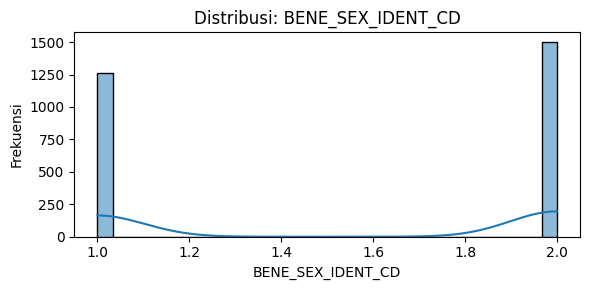

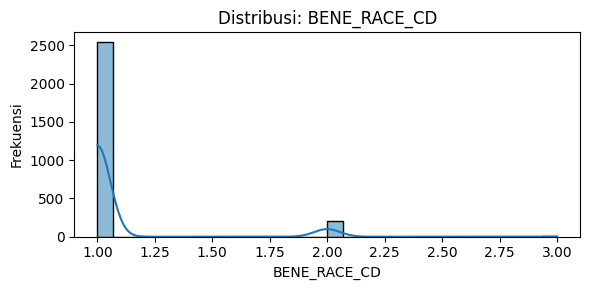

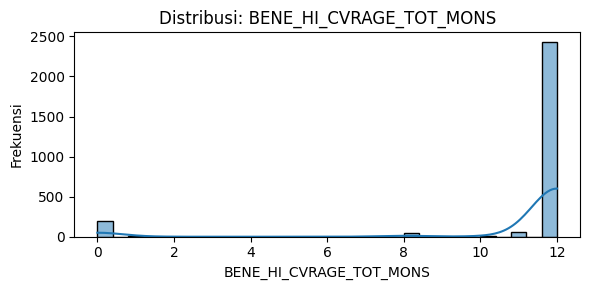

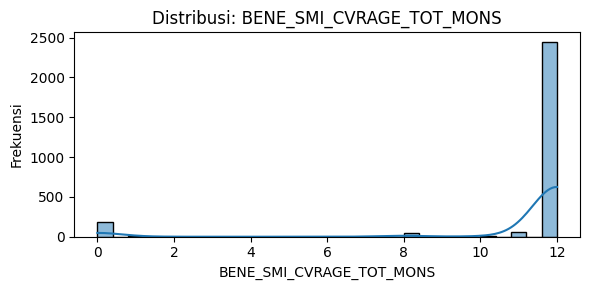

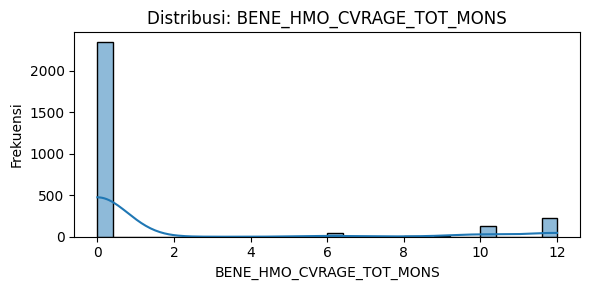

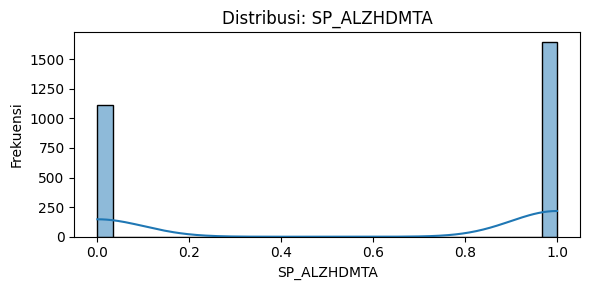

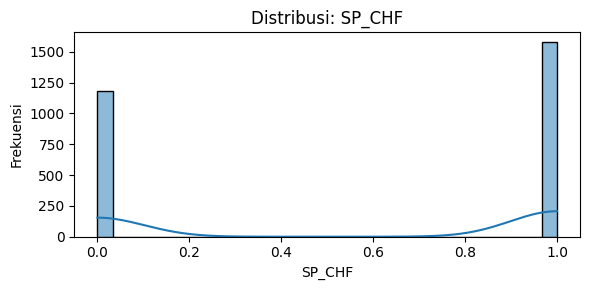

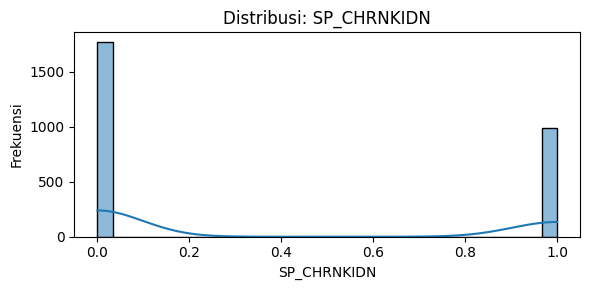

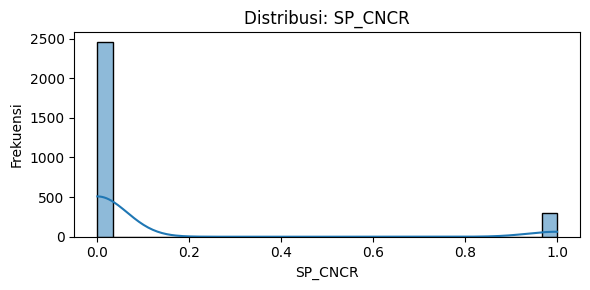

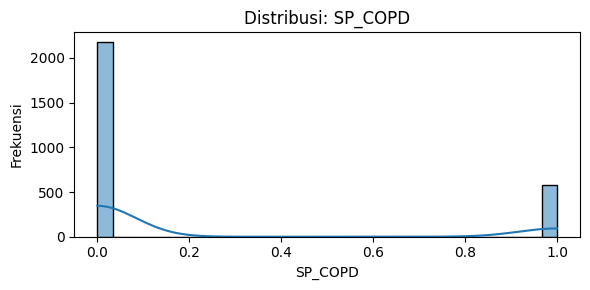

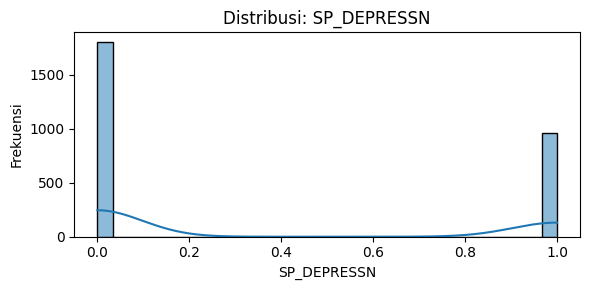

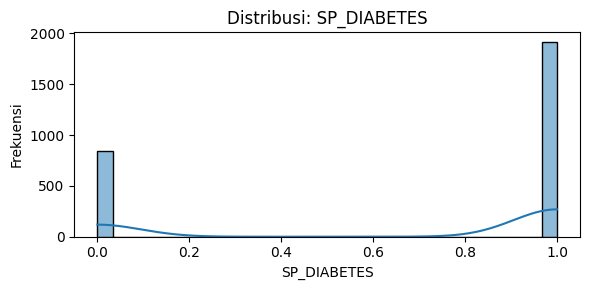

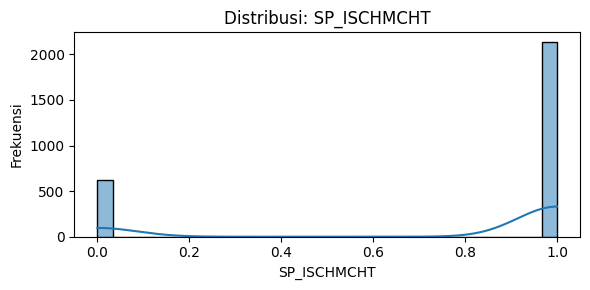

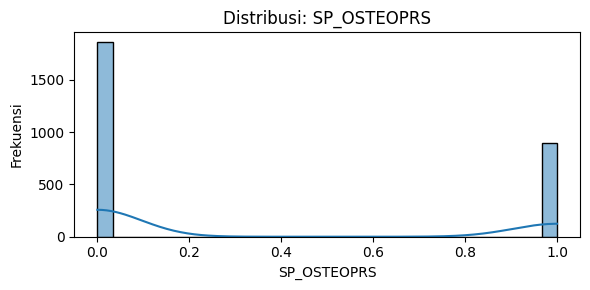

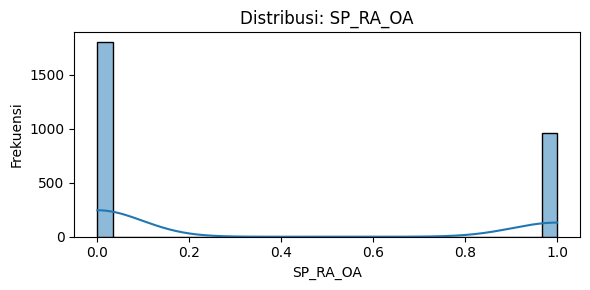

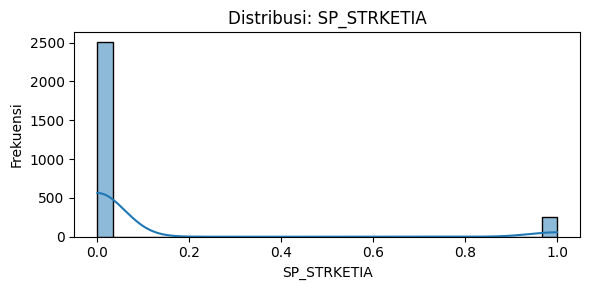

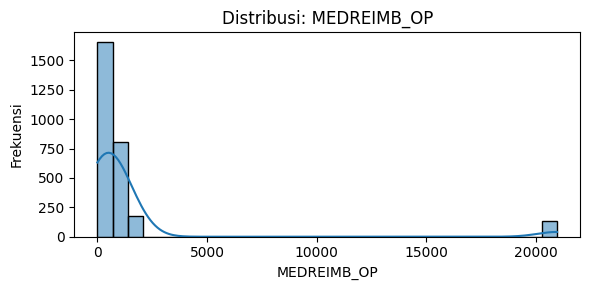

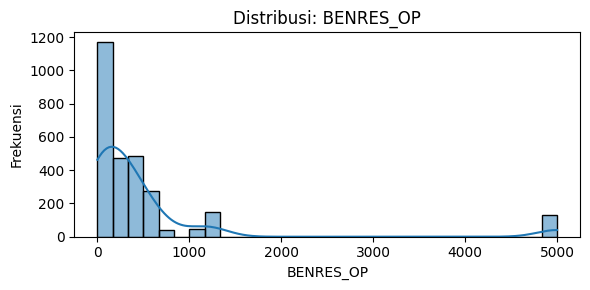

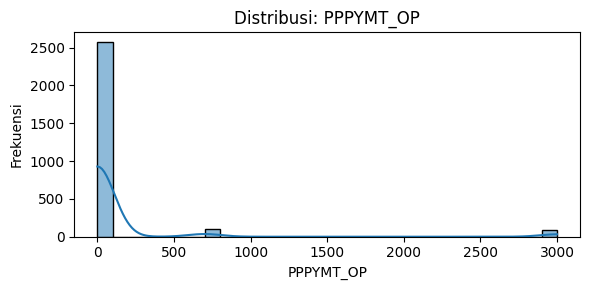

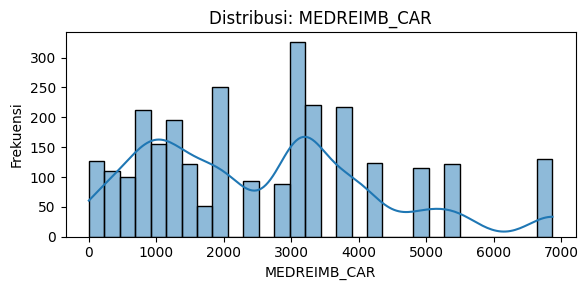

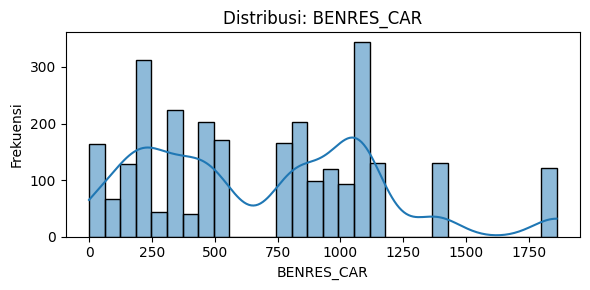

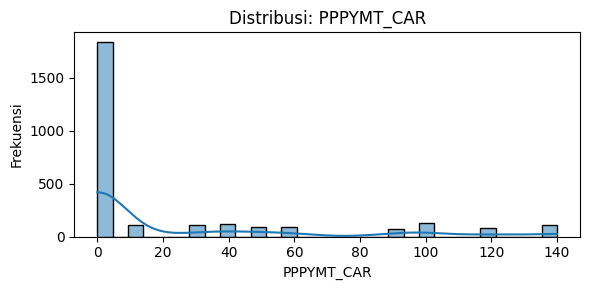

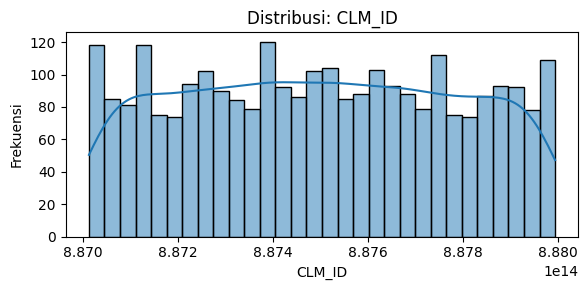

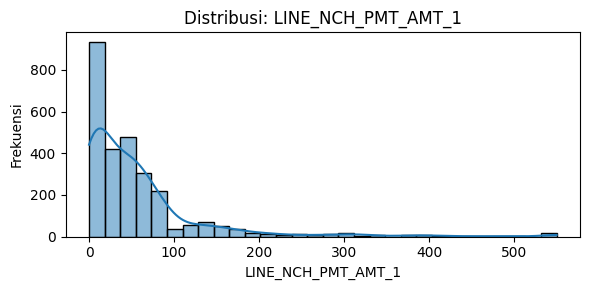

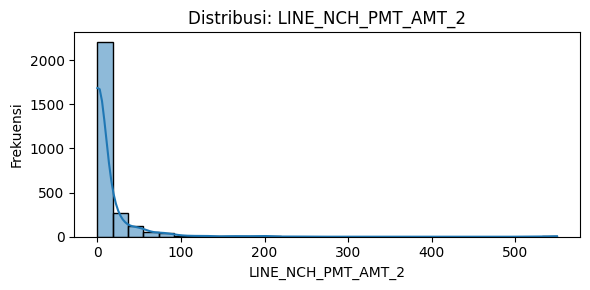

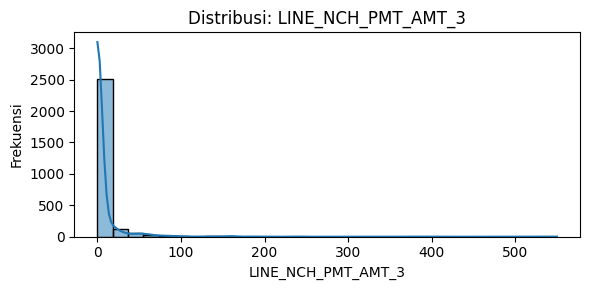

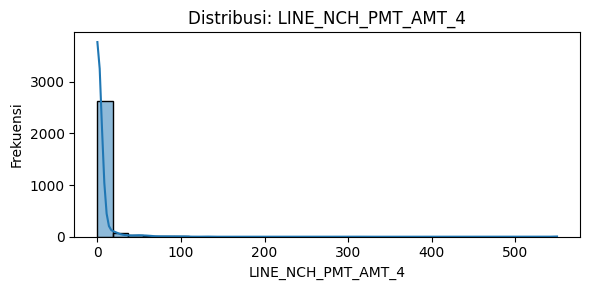

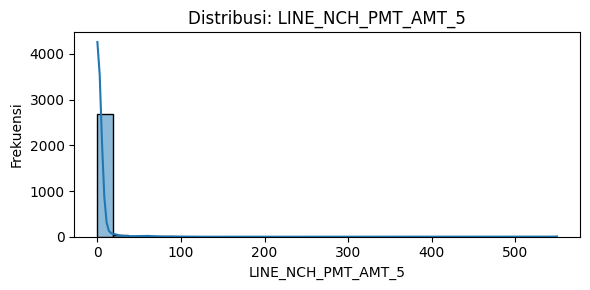

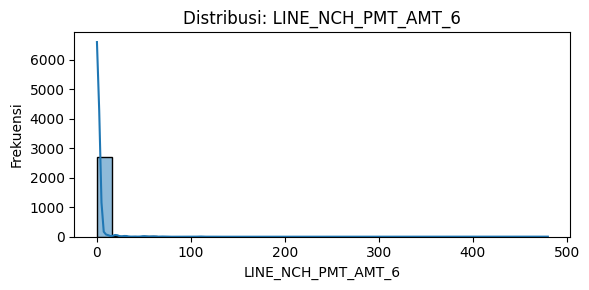

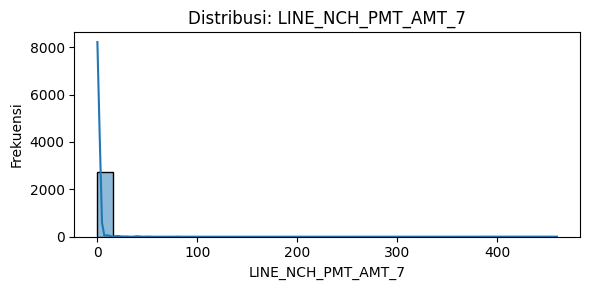

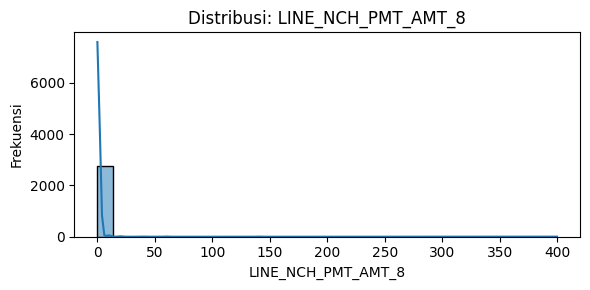

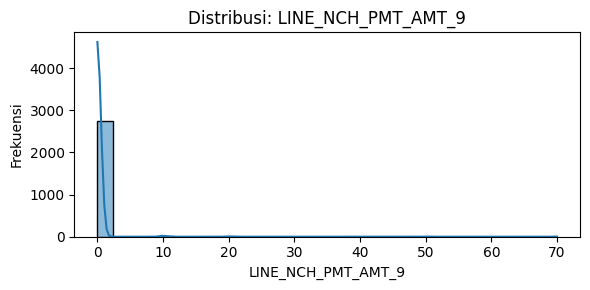

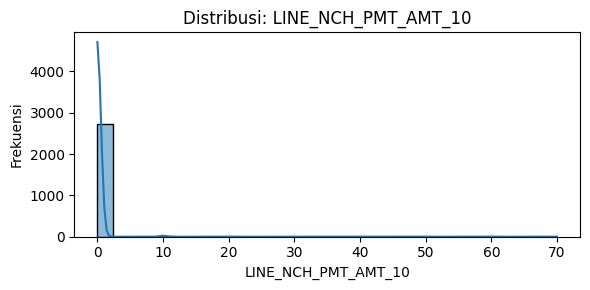

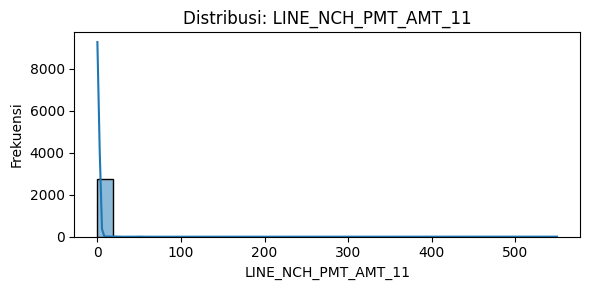

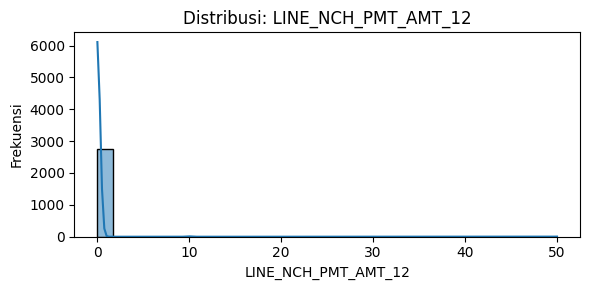

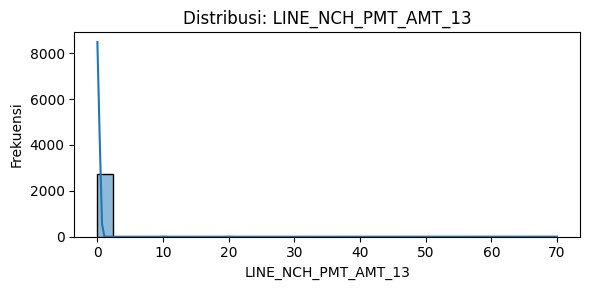

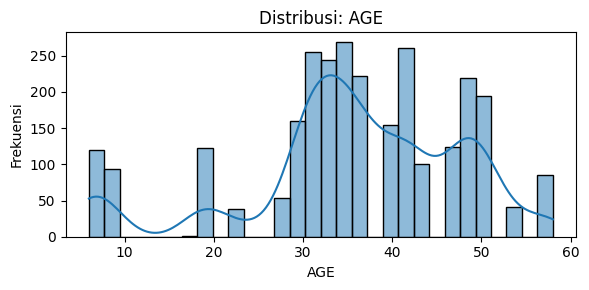

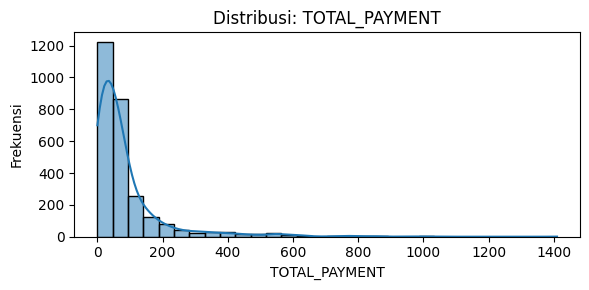

In [ ]:
# 2. Distribusi Kolom Numerik
num_cols = df2.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df2[col], bins=30, kde=True)
    plt.title(f'Distribusi: {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

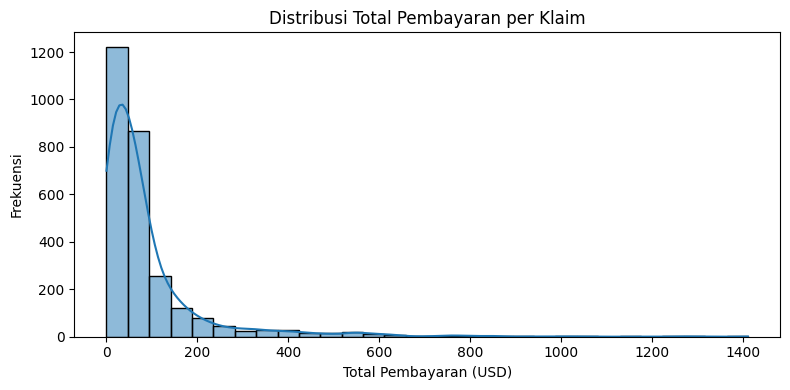

In [ ]:
# 3. Distribusi Pembayaran
plt.figure(figsize=(8, 4))
sns.histplot(df2['TOTAL_PAYMENT'], bins=30, kde=True)
plt.title('Distribusi Total Pembayaran per Klaim')
plt.xlabel('Total Pembayaran (USD)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

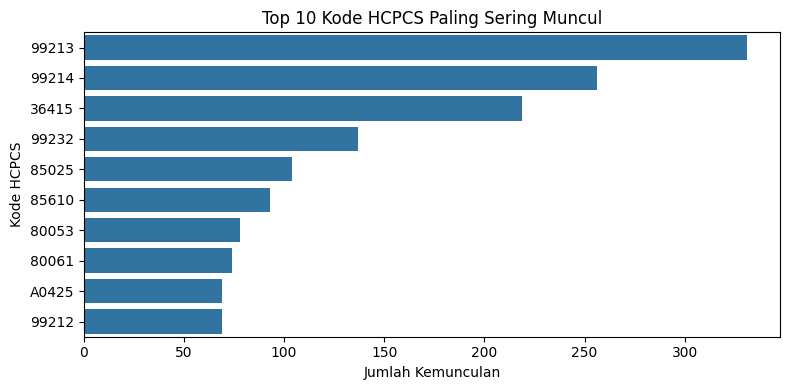

In [ ]:
# 4. Top 10 Kode HCPCS
all_hcpcs = df2['HCPCS_LIST'].explode()
top10 = all_hcpcs.value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(y=top10.index, x=top10.values)
plt.title('Top 10 Kode HCPCS Paling Sering Muncul')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Kode HCPCS')
plt.tight_layout()
plt.show()

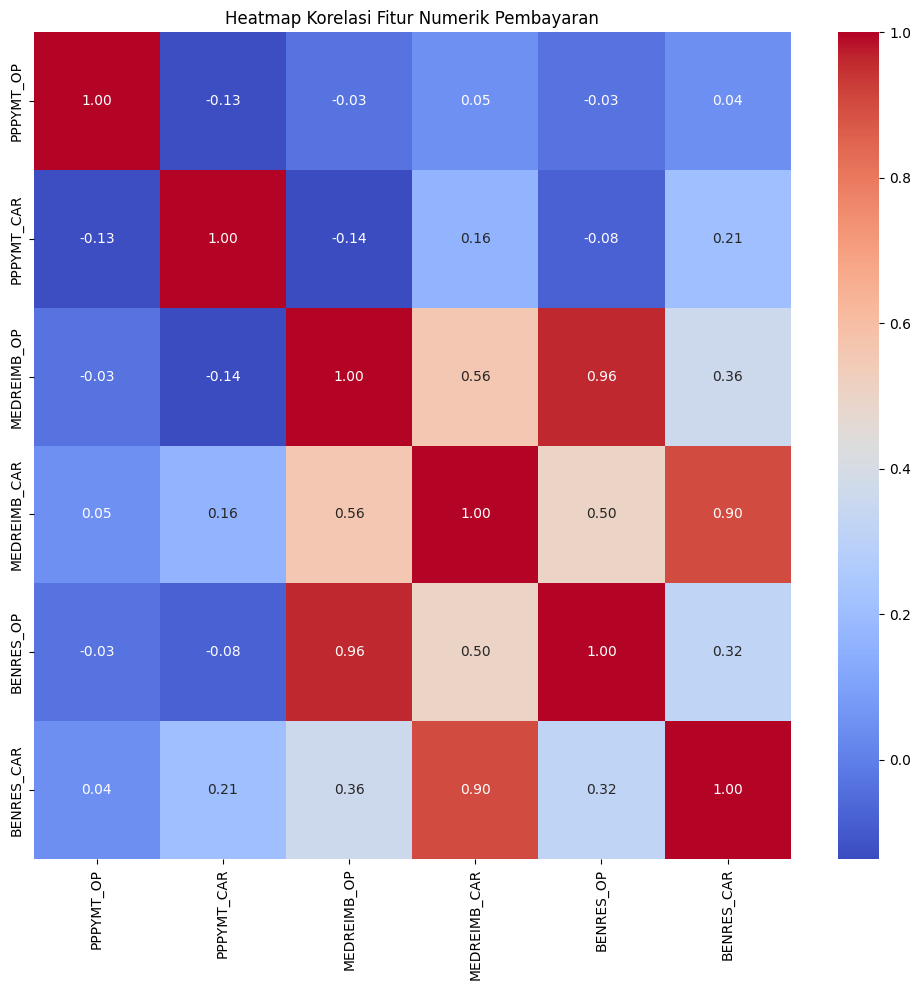

In [ ]:
# 5. Heatmap Korelasi Numerik
# membantu deteksi hubungan linear atau redudansi fitur
plt.figure(figsize=(10, 10))
num_cols = ['PPPYMT_OP', 'PPPYMT_CAR', 'MEDREIMB_OP', 'MEDREIMB_CAR', 'BENRES_OP', 'BENRES_CAR']
corr = df2[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik Pembayaran')
plt.tight_layout()
plt.show()

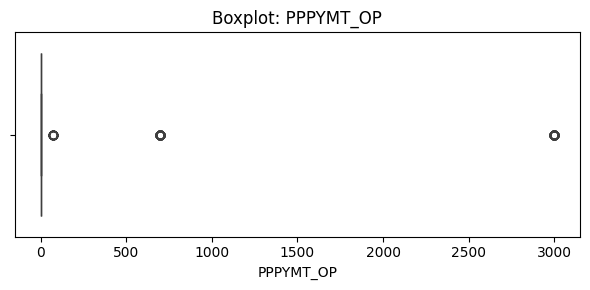

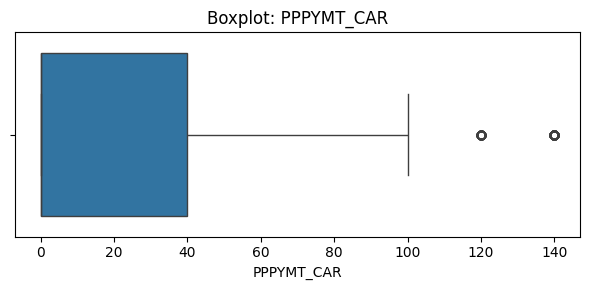

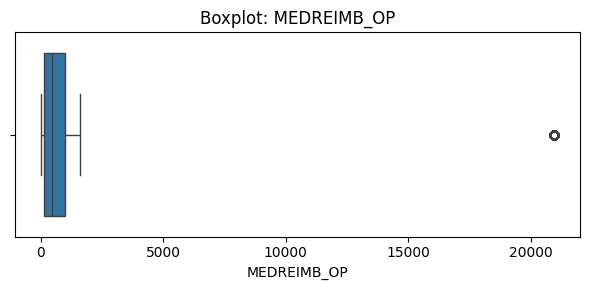

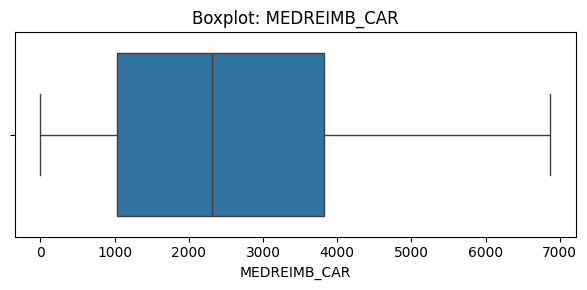

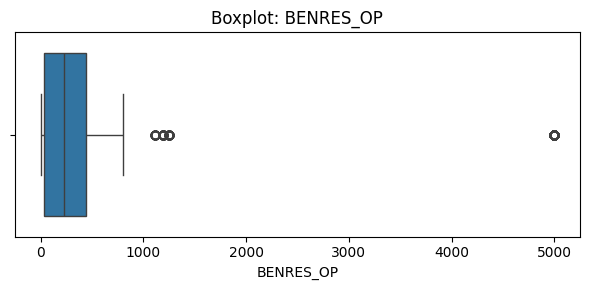

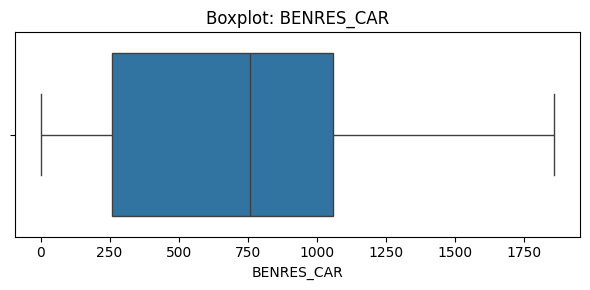

In [ ]:
# 6. Boxplot untuk Deteksi Outlier
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df2[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

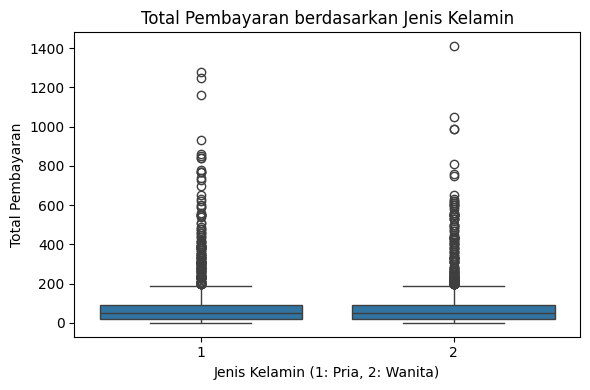

In [ ]:
# 7. Boxplot total pembayaran berdasarkan jenis kelamin
plt.figure(figsize=(6, 4))
sns.boxplot(x='BENE_SEX_IDENT_CD', y='TOTAL_PAYMENT', data=df2)
plt.title('Total Pembayaran berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin (1: Pria, 2: Wanita)')
plt.ylabel('Total Pembayaran')
plt.tight_layout()
plt.show()

# Clustering

In [ ]:
continuous_cols = ['AGE', 'TOTAL_PAYMENT', 'BENE_HI_CVRAGE_TOT_MONS',
                   'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS','MEDREIMB_OP', 'BENRES_OP']
sp_columns = [col for col in df2.columns if col.startswith('SP_')]

# Subset
df_cont = df2[continuous_cols].copy()
df_bin  = df2[sp_columns].copy()

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cont), columns=continuous_cols, index=df2.index)

# Gabungkan kembali
df_scaled = pd.concat([df_scaled, df_bin], axis=1)


In [ ]:
df_scaled

,AGE,TOTAL_PAYMENT,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,MEDREIMB_OP,BENRES_OP,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA
0,1.014746,0.812030,0.314415,0.303941,2.189627,4.470005,4.289854,1,1,1,0,1,0,1,1,0,0,1
1,1.014746,-0.680691,0.314415,0.303941,2.189627,4.470005,4.289854,1,1,1,0,1,0,1,1,0,0,1
2,1.014746,-0.602127,0.314415,0.303941,2.189627,4.470005,4.289854,1,1,1,0,1,0,1,1,0,0,1
3,1.014746,3.483216,0.314415,0.303941,2.189627,4.470005,4.289854,1,1,1,0,1,0,1,1,0,0,1
4,1.014746,-0.680691,0.314415,0.303941,2.189627,4.470005,4.289854,1,1,1,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,0.681478,-0.052177,0.314415,0.303941,-0.412022,-0.179147,-0.240786,0,0,0,0,1,1,0,0,0,0,0
2756,0.681478,-0.209306,0.314415,0.303941,-0.412022,-0.179147,-0.240786,0,0,0,0,1,1,0,0,0,0,0
2757,0.681478,-0.680691,0.314415,0.303941,-0.412022,-0.179147,-0.240786,0,0,0,0,1,1,0,0,0,0,0
2758,-0.568276,-0.287870,0.314415,0.303941,-0.412022,-0.349378,-0.489302,0,0,0,0,0,0,0,0,0,0,0


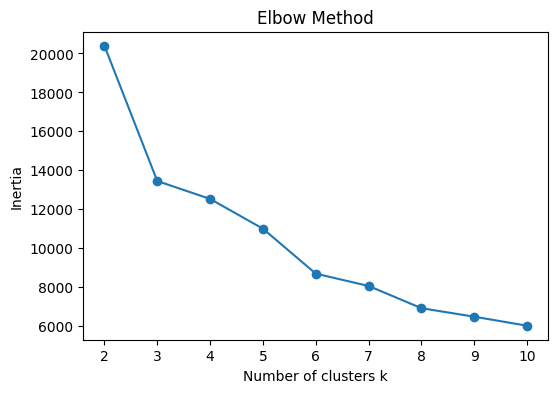

k=3 → Silhouette Score = 0.531
k=4 → Silhouette Score = 0.189
k=5 → Silhouette Score = 0.198
cluster
1    2423
0     207
2     130
Name: count, dtype: int64


In [ ]:
# Elbow Method
inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Coba silhouette score untuk k pilihan
for k in [3,4,5]:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    print(f"k={k} → Silhouette Score = {score:.3f}")

# Pilih k terbaik
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
df2['cluster'] = kmeans.fit_predict(df_scaled)


print(df2['cluster'].value_counts())

In [ ]:
labels = df2['cluster']

score = silhouette_score(df_scaled, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.531



=== Statistik Deskriptif per Cluster ===
               AGE                           TOTAL_PAYMENT                     \
              mean median        std min max          mean median         std   
cluster                                                                         
0        35.120773   39.0   5.307066  27  42     72.077295   40.0  108.543016   
1        35.226991   35.0  12.385815   6  58     86.293851   50.0  127.749559   
2        48.000000   48.0   0.000000  48  48    116.307692   70.0  142.051080   

                      ... BENE_SMI_CVRAGE_TOT_MONS                           \
         min     max  ...                     mean median       std min max   
cluster               ...                                                     
0        0.0   770.0  ...                 0.893720    0.0  3.115621   0  12   
1        0.0  1410.0  ...                11.886504   12.0  0.582496   8  12   
2        0.0   760.0  ...                12.000000   12.0  0.000000  12  12 

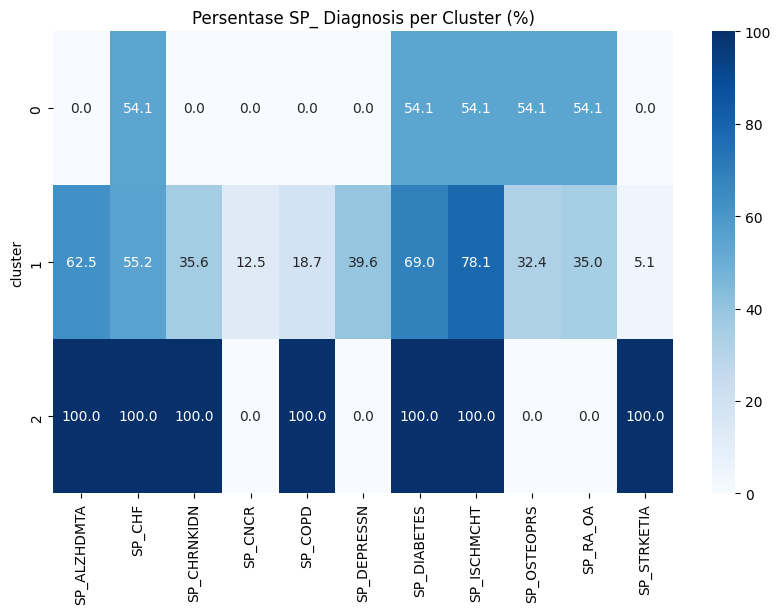

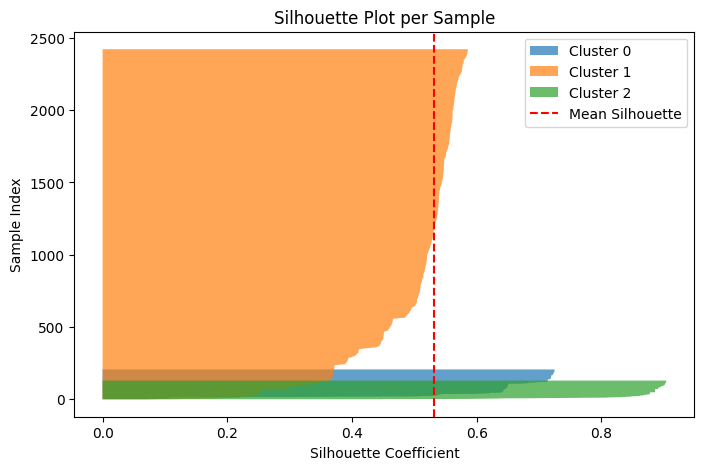


=== Jumlah Anggota Tiap Cluster ===
cluster
1    2423
0     207
2     130
Name: count, dtype: int64


In [ ]:
import seaborn as sns

# Statistik Deskriptif per Cluster
summary = df2.groupby('cluster')[['AGE', 'TOTAL_PAYMENT',
                                  'BENE_HI_CVRAGE_TOT_MONS',
                                  'BENE_SMI_CVRAGE_TOT_MONS',
                                  'BENE_HMO_CVRAGE_TOT_MONS']].agg(['mean', 'median', 'std', 'min', 'max'])
print("\n=== Statistik Deskriptif per Cluster ===")
print(summary)

# Komposisi SP_ Diagnosis
sp_counts = df2.groupby('cluster')[sp_columns].mean() * 100
plt.figure(figsize=(10,6))
sns.heatmap(sp_counts, annot=True, fmt=".1f", cmap="Blues")
plt.title("Persentase SP_ Diagnosis per Cluster (%)")
plt.show()

# Silhouette Plot per Sample
from sklearn.metrics import silhouette_samples
import numpy as np

silhouette_vals = silhouette_samples(df_scaled, df2['cluster'])
df2['silhouette'] = silhouette_vals

plt.figure(figsize=(8,5))
for c in range(best_k):
    c_silhouette = df2[df2['cluster'] == c]['silhouette']
    c_silhouette_sorted = np.sort(c_silhouette)
    plt.fill_betweenx(np.arange(len(c_silhouette_sorted)),
                      0, c_silhouette_sorted,
                      alpha=0.7, label=f'Cluster {c}')
plt.axvline(df2['silhouette'].mean(), color="red", linestyle="--", label="Mean Silhouette")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Sample Index")
plt.title("Silhouette Plot per Sample")
plt.legend()
plt.show()


print("\n=== Jumlah Anggota Tiap Cluster ===")
print(df2['cluster'].value_counts())

In [ ]:
# Profilisasi Cluster
def describe_cluster(cluster_id, df, diag_percent, features):
    print(f"\n=== Profil Cluster {cluster_id} ===")
    sub_df = df[df['cluster'] == cluster_id]

    print(f"Jumlah Anggota: {len(sub_df)}")
    print(f"Rata-rata Usia: {sub_df['AGE'].mean():.2f} (Median: {sub_df['AGE'].median()}, Min: {sub_df['AGE'].min()}, Max: {sub_df['AGE'].max()})")
    print(f"Total Payment Rata-rata: {sub_df['TOTAL_PAYMENT'].mean():.2f}")
    print(f"SMI Coverage Bulanan Rata-rata: {sub_df['BENE_SMI_CVRAGE_TOT_MONS'].mean():.2f}")
    print(f"HMO Coverage Bulanan Rata-rata: {sub_df['BENE_HMO_CVRAGE_TOT_MONS'].mean():.2f}")

    print("\nDiagnosis Umum:")
    cluster_diag = diag_percent.loc[cluster_id]
    for col in cluster_diag.index:
        if cluster_diag[col] > 30:
            print(f" - {col}: {cluster_diag[col]:.1f}%")

sp_columns = [col for col in df2.columns if col.startswith('SP_')]
diagnosis_percent = df2.groupby('cluster')[sp_columns].mean() * 100

for cluster_id in sorted(df2['cluster'].unique()):
    describe_cluster(cluster_id, df2, diagnosis_percent, features=['AGE', 'TOTAL_PAYMENT', 'BENE_SMI_CVRAGE_TOT_MONS', 'BENE_HMO_CVRAGE_TOT_MONS'])



=== Profil Cluster 0 ===
Jumlah Anggota: 207
Rata-rata Usia: 35.12 (Median: 39.0, Min: 27, Max: 42)
Total Payment Rata-rata: 72.08
SMI Coverage Bulanan Rata-rata: 0.89
HMO Coverage Bulanan Rata-rata: 0.50

Diagnosis Umum:
 - SP_CHF: 54.1%
 - SP_DIABETES: 54.1%
 - SP_ISCHMCHT: 54.1%
 - SP_OSTEOPRS: 54.1%
 - SP_RA_OA: 54.1%

=== Profil Cluster 1 ===
Jumlah Anggota: 2423
Rata-rata Usia: 35.23 (Median: 35.0, Min: 6, Max: 58)
Total Payment Rata-rata: 86.29
SMI Coverage Bulanan Rata-rata: 11.89
HMO Coverage Bulanan Rata-rata: 1.22

Diagnosis Umum:
 - SP_ALZHDMTA: 62.5%
 - SP_CHF: 55.2%
 - SP_CHRNKIDN: 35.6%
 - SP_DEPRESSN: 39.6%
 - SP_DIABETES: 69.0%
 - SP_ISCHMCHT: 78.1%
 - SP_OSTEOPRS: 32.4%
 - SP_RA_OA: 35.0%

=== Profil Cluster 2 ===
Jumlah Anggota: 130
Rata-rata Usia: 48.00 (Median: 48.0, Min: 48, Max: 48)
Total Payment Rata-rata: 116.31
SMI Coverage Bulanan Rata-rata: 12.00
HMO Coverage Bulanan Rata-rata: 10.00

Diagnosis Umum:
 - SP_ALZHDMTA: 100.0%
 - SP_CHF: 100.0%
 - SP_CHRNKIDN: 

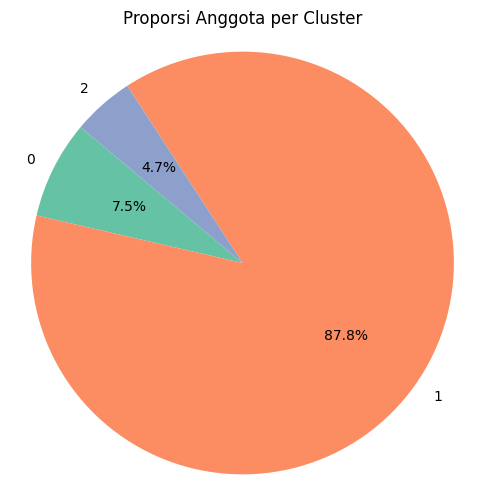

In [ ]:
cluster_counts = df2['cluster'].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(cluster_counts, labels=cluster_counts.index,
        autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
plt.title("Proporsi Anggota per Cluster")
plt.axis('equal')
plt.show()

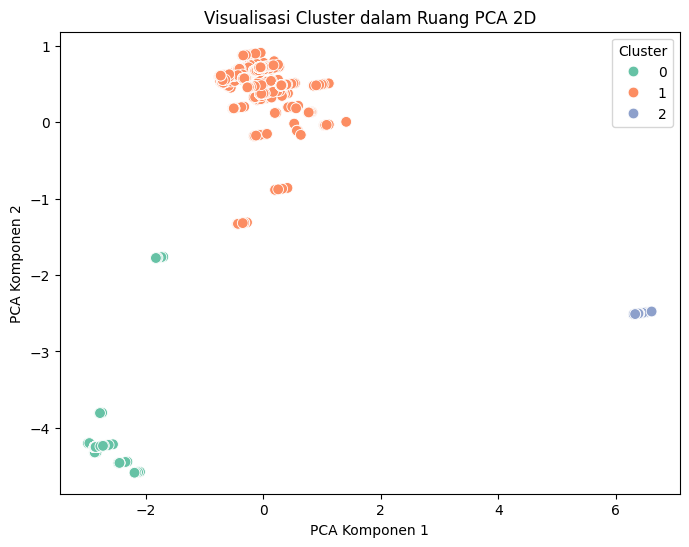

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

df2['PCA1'] = pca_result[:, 0]
df2['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df2, palette='Set2', s=60)
plt.title("Visualisasi Cluster dalam Ruang PCA 2D")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.legend(title="Cluster")
plt.show()

<ipython-input-104-1275366911>:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[df2['cluster'] == cluster_id]['AGE'], label=f'Cluster {cluster_id}', fill=True)


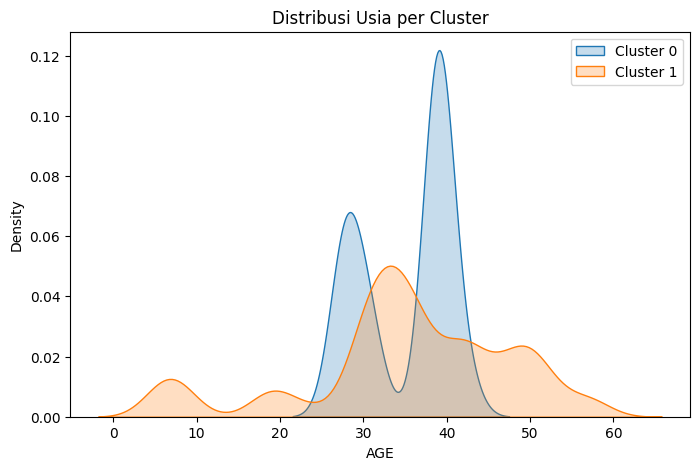

In [ ]:
plt.figure(figsize=(8,5))
for cluster_id in sorted(df2['cluster'].unique()):
    sns.kdeplot(df2[df2['cluster'] == cluster_id]['AGE'], label=f'Cluster {cluster_id}', fill=True)

plt.title("Distribusi Usia per Cluster")
plt.xlabel("AGE")
plt.ylabel("Density")
plt.legend()
plt.show()

# Association Rule Mining

HCPCS terpilih (muncul di ≥3 cluster): 41

===== Cluster: 0 (207 data) =====

Frequent Itemsets (65 ditemukan):


,support,itemsets
6,0.913043,(LOW_PAYMENT)
0,0.676329,(AGE_30-39)
12,0.599034,"(AGE_30-39, LOW_PAYMENT)"
3,0.541063,(HAS_ISCHMCHT)
1,0.541063,(HAS_CHF)
...,...,...
60,0.541063,"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO..."
61,0.541063,"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO..."
62,0.541063,"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA..."
63,0.541063,"(HAS_DIABETES, HAS_ISCHMCHT, HAS_RA_OA, HAS_OS..."



Association Rules (571 ditemukan):


,antecedents,consequents,support,confidence,lift
571,(HAS_CHF),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
570,(HAS_OSTEOPRS),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
569,(HAS_RA_OA),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_OS...",0.541063,1.0,1.848214
568,(HAS_ISCHMCHT),"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO...",0.541063,1.0,1.848214
567,(HAS_DIABETES),"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO...",0.541063,1.0,1.848214
...,...,...,...,...,...
4,(HAS_RA_OA),(AGE_30-39),0.541063,1.0,1.478571
3,(HAS_OSTEOPRS),(AGE_30-39),0.541063,1.0,1.478571
2,(HAS_ISCHMCHT),(AGE_30-39),0.541063,1.0,1.478571
1,(HAS_DIABETES),(AGE_30-39),0.541063,1.0,1.478571


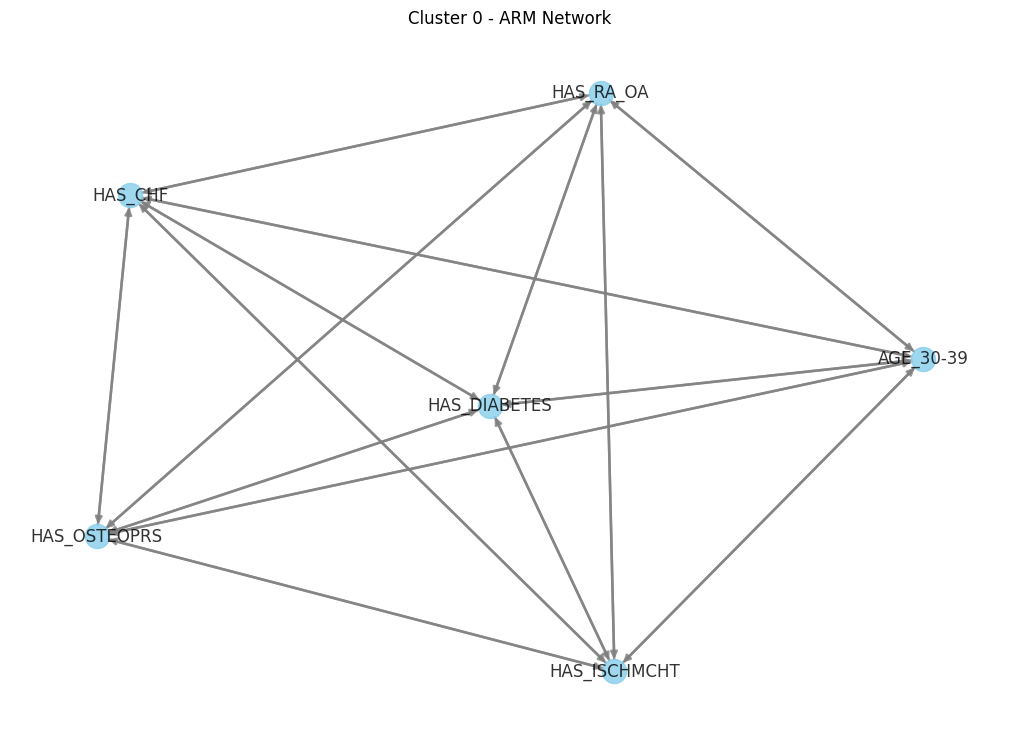


===== Cluster: 1 (2423 data) =====

Frequent Itemsets (48 ditemukan):


,support,itemsets
9,0.903838,(LOW_PAYMENT)
6,0.781263,(HAS_ISCHMCHT)
29,0.700784,"(HAS_ISCHMCHT, LOW_PAYMENT)"
5,0.690054,(HAS_DIABETES)
26,0.647132,"(HAS_DIABETES, HAS_ISCHMCHT)"
1,0.625258,(HAS_ALZHDMTA)
27,0.622782,"(HAS_DIABETES, LOW_PAYMENT)"
44,0.581098,"(HAS_DIABETES, HAS_ISCHMCHT, LOW_PAYMENT)"
17,0.566240,"(HAS_ALZHDMTA, LOW_PAYMENT)"
2,0.551795,(HAS_CHF)



Association Rules (22 ditemukan):


,antecedents,consequents,support,confidence,lift
24,"(HAS_ISCHMCHT, HAS_DEPRESSN)",(HAS_ALZHDMTA),0.317375,0.989704,1.582873
25,(HAS_DEPRESSN),"(HAS_ALZHDMTA, HAS_ISCHMCHT)",0.317375,0.801042,1.470397
39,(HAS_CHRNKIDN),"(HAS_DIABETES, HAS_ISCHMCHT)",0.328106,0.922274,1.425172
2,(HAS_DEPRESSN),(HAS_ALZHDMTA),0.335534,0.846875,1.354441
38,"(HAS_ISCHMCHT, HAS_CHRNKIDN)",(HAS_DIABETES),0.328106,0.922274,1.336525
7,(HAS_CHRNKIDN),(HAS_DIABETES),0.328106,0.922274,1.336525
42,(HAS_CHRNKIDN),"(HAS_ISCHMCHT, LOW_PAYMENT)",0.321915,0.904872,1.291228
37,"(HAS_DIABETES, HAS_CHRNKIDN)",(HAS_ISCHMCHT),0.328106,1.000000,1.279979
41,"(HAS_CHRNKIDN, LOW_PAYMENT)",(HAS_ISCHMCHT),0.321915,1.000000,1.279979
8,(HAS_CHRNKIDN),(HAS_ISCHMCHT),0.355757,1.000000,1.279979


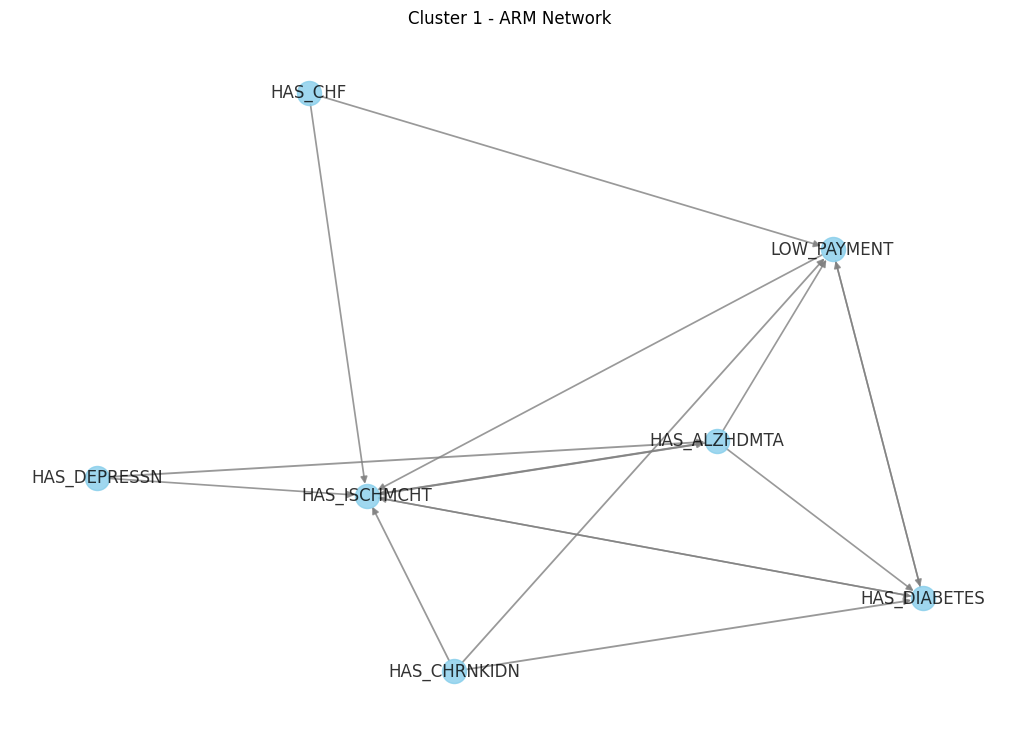


===== Cluster: 2 (130 data) =====

Frequent Itemsets (511 ditemukan):


,support,itemsets
501,1.000000,"(HAS_COPD, HAS_CHRNKIDN, HAS_ALZHDMTA, HAS_DIA..."
0,1.000000,(AGE_40-49)
1,1.000000,(HAS_ALZHDMTA)
2,1.000000,(HAS_CHF)
3,1.000000,(HAS_CHRNKIDN)
...,...,...
506,0.830769,"(HAS_COPD, LOW_PAYMENT, HAS_ALZHDMTA, HAS_DIAB..."
507,0.830769,"(HAS_COPD, HAS_CHRNKIDN, LOW_PAYMENT, HAS_ALZH..."
508,0.830769,"(HAS_COPD, HAS_CHRNKIDN, LOW_PAYMENT, HAS_DIAB..."
509,0.830769,"(HAS_COPD, HAS_CHRNKIDN, LOW_PAYMENT, HAS_ALZH..."



Association Rules (18660 ditemukan):


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


,antecedents,consequents,support,confidence,lift
18659,(HAS_STRKETIA),"(HAS_COPD, HAS_CHRNKIDN, LOW_PAYMENT, HAS_ALZH...",0.830769,0.830769,1.0
0,(HAS_ALZHDMTA),(AGE_40-49),1.000000,1.000000,1.0
1,(AGE_40-49),(HAS_ALZHDMTA),1.000000,1.000000,1.0
2,(AGE_40-49),(HAS_CHF),1.000000,1.000000,1.0
18643,"(HAS_DIABETES, HAS_CHF)","(HAS_COPD, HAS_CHRNKIDN, LOW_PAYMENT, HAS_ALZH...",0.830769,0.830769,1.0
...,...,...,...,...,...
8,(HAS_DIABETES),(AGE_40-49),1.000000,1.000000,1.0
7,(HAS_COPD),(AGE_40-49),1.000000,1.000000,1.0
6,(AGE_40-49),(HAS_COPD),1.000000,1.000000,1.0
5,(HAS_CHRNKIDN),(AGE_40-49),1.000000,1.000000,1.0


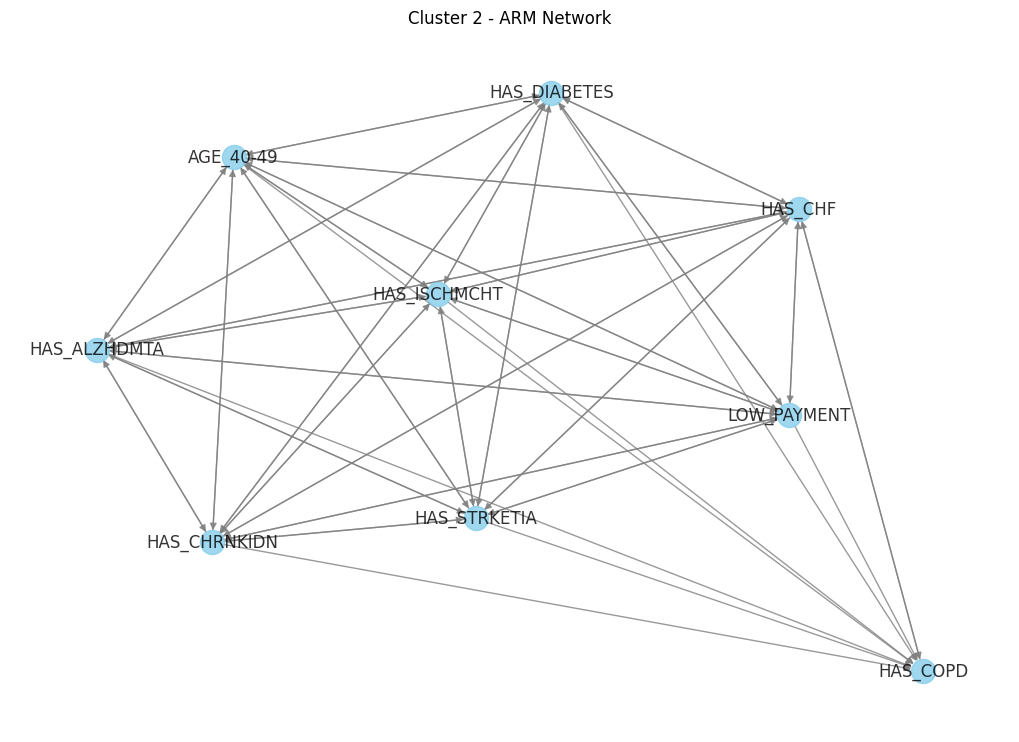

In [ ]:
def enrich_hcpcs_list(df):
    enriched_list = []
    sp_columns = [col for col in df.columns if col.startswith('SP_')]

    for _, row in df.iterrows():
        items = list(map(str, row['HCPCS_LIST']))

        for col in sp_columns:
            if row[col] == 1:
                items.append(f"HAS_{col[3:]}")

        age_group = f"AGE_{(row['AGE']//10)*10}-{(row['AGE']//10)*10+9}"
        items.append(age_group)

        if row['TOTAL_PAYMENT'] >= 500:
            items.append('HIGH_PAYMENT')
        elif row['TOTAL_PAYMENT'] >= 200:
            items.append('MIDDLE_PAYMENT')
        else:
            items.append('LOW_PAYMENT')

        enriched_list.append(items)

    df['HCPCS_LIST'] = enriched_list
    return df

def filter_hcpcs_multi_cluster(df, min_clusters=3):
    hcpcs_per_cluster = {}
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        hcpcs = pd.Series(sum(cluster_data['HCPCS_LIST'], [])).value_counts()
        hcpcs_per_cluster[cluster] = set(hcpcs.index)

    hcpcs_counter = Counter()
    for cluster_hcpcs in hcpcs_per_cluster.values():
        hcpcs_counter.update(cluster_hcpcs)

    selected_hcpcs = {hcpcs for hcpcs, count in hcpcs_counter.items() if count >= min_clusters}
    print(f"HCPCS terpilih (muncul di ≥{min_clusters} cluster): {len(selected_hcpcs)}")
    return selected_hcpcs

def run_arm(df, selected_hcpcs, min_support, min_confidence, lift_threshold=1.3, top_n=10):
    transactions = []
    for items in df['HCPCS_LIST']:
        filtered_items = [item for item in items if (item in selected_hcpcs or item.startswith('HAS_') or item.startswith('AGE_') or item == 'HIGH_PAYMENT')]
        transactions.append(filtered_items)

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    print(f"\nFrequent Itemsets ({len(frequent_itemsets)} ditemukan):")
    display(frequent_itemsets.sort_values(by='support', ascending=False))

    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules = rules[rules['lift'] >= lift_threshold]

    rules = rules.sort_values(by='lift', ascending=False)

    if rules.empty:
        print("\nTidak ada association rules yang ditemukan.")
    else:
        print(f"\nAssociation Rules ({len(rules)} ditemukan):")
        display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

    return rules

def plot_arm_network(rules, top_n=10, title="ARM Network"):
    if rules.empty:
        print("Tidak ada rules untuk divisualisasikan.")
        return

    rules = rules.head(top_n)
    G = nx.DiGraph()

    for _, row in rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(antecedent, consequent, weight=row['lift'], confidence=row['confidence'])

    pos = nx.spring_layout(G, k=0.7, iterations=50)
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]

    plt.figure(figsize=(10,7))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=edge_weights, arrows=True, alpha=0.8)
    plt.title(title)
    plt.show()

# Main Process
df2 = enrich_hcpcs_list(df2)
selected_hcpcs = filter_hcpcs_multi_cluster(df2, min_clusters=3)

rules_cluster0 = None
rules_cluster1 = None
rules_cluster2 = None

for cluster_id in sorted(df2['cluster'].unique()):
    df_cluster = df2[df2['cluster'] == cluster_id]
    if df_cluster.empty:
        print(f"\nCluster {cluster_id} kosong, dilewati.")
        continue

    print(f"\n===== Cluster: {cluster_id} ({len(df_cluster)} data) =====")

    if cluster_id == 0:
        params = {'min_support': 0.5, 'min_confidence': 0.8, 'lift_threshold': 1.2}
    elif cluster_id == 1:
        params = {'min_support': 0.3, 'min_confidence': 0.8, 'lift_threshold': 1.2}
    elif cluster_id == 2:
        params = {'min_support': 0.6, 'min_confidence': 0.8, 'lift_threshold': 1.0}
    else:
        print(f"Cluster {cluster_id} tidak punya parameter spesifik, dilewati.")
        continue

    rules = run_arm(df_cluster, selected_hcpcs, **params, top_n=30)

    if cluster_id == 0:
        rules_cluster0 = rules
    elif cluster_id == 1:
        rules_cluster1 = rules
    elif cluster_id == 2:
        rules_cluster2 = rules

    if rules is not None and not rules.empty:
        plot_arm_network(rules, top_n=30, title=f"Cluster {cluster_id} - ARM Network")



## Analisis Lanjut untuk Cluster 0

In [ ]:
# Diagnosis kronis SP_ yang umum di cluster 1 dan 0
sp_cluster1 = df2[df2['cluster'] == 1][sp_columns].mean().sort_values(ascending=False) * 100

print("\n=== Diagnosis SP_ Umum di Kluster 1 (persentase pasien) ===")
print(sp_cluster1.head(10))

sp_cluster0 = df2[df2['cluster'] == 0][sp_columns].mean().sort_values(ascending=False) * 100

print("\n=== Diagnosis SP_ Umum di Kluster 0 (persentase pasien) ===")
print(sp_cluster0.head(10))



=== Diagnosis SP_ Umum di Kluster 1 (persentase pasien) ===
SP_ISCHMCHT    78.126290
SP_DIABETES    69.005365
SP_ALZHDMTA    62.525794
SP_CHF         55.179530
SP_DEPRESSN    39.620305
SP_CHRNKIDN    35.575733
SP_RA_OA       34.997936
SP_OSTEOPRS    32.397854
SP_COPD        18.695832
SP_CNCR        12.546430
dtype: float64

=== Diagnosis SP_ Umum di Kluster 0 (persentase pasien) ===
SP_CHF         54.10628
SP_RA_OA       54.10628
SP_DIABETES    54.10628
SP_OSTEOPRS    54.10628
SP_ISCHMCHT    54.10628
SP_CHRNKIDN     0.00000
SP_ALZHDMTA     0.00000
SP_DEPRESSN     0.00000
SP_COPD         0.00000
SP_CNCR         0.00000
dtype: float64


In [ ]:
# Ambil SP_ dengan nilai > 0 di masing-masing klaster
sp0_muncul = sp_cluster0[sp_cluster0 > 0].index.tolist()
sp1_muncul = sp_cluster1[sp_cluster1 > 0].index.tolist()

# Ambil SP_ yang muncul di kedua klaster
sp_muncul_keduanya = list(set(sp0_muncul) & set(sp1_muncul))

print("SP_ yang muncul di kedua klaster")
print(sp_muncul_keduanya)

SP_ yang muncul di kedua klaster
['SP_CHF', 'SP_RA_OA', 'SP_OSTEOPRS', 'SP_ISCHMCHT', 'SP_DIABETES']


In [ ]:
def filter_rules_for_sp(rules_df, sp_code):
    target = f"HAS_{sp_code[3:]}"
    filtered = rules_df[
        rules_df['antecedents'].apply(lambda x: target in x) |
        rules_df['consequents'].apply(lambda x: target in x)
    ]
    return filtered

sp_to_analyze = 'SP_ISCHMCHT'

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 0 =====")
if rules_cluster0 is not None:
    filtered_rules_0 = filter_rules_for_sp(rules_cluster0, sp_to_analyze)
    if filtered_rules_0.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 0.")
    else:
        display(filtered_rules_0[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 1 =====")
if rules_cluster1 is not None:
    filtered_rules_1 = filter_rules_for_sp(rules_cluster1, sp_to_analyze)
    filtered_rules_1 = filtered_rules_1[filtered_rules_1['support'] >= 0.5]  # Filter support minimal 0.5 di sini, setelah ARM selesai
    if filtered_rules_1.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.")
    else:
        display(filtered_rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


===== Aturan ARM yang memuat SP_ISCHMCHT pada Cluster 0 =====


,antecedents,consequents,support,confidence,lift
571,(HAS_CHF),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
570,(HAS_OSTEOPRS),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
569,(HAS_RA_OA),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_OS...",0.541063,1.0,1.848214
568,(HAS_ISCHMCHT),"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO...",0.541063,1.0,1.848214
567,(HAS_DIABETES),"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO...",0.541063,1.0,1.848214
...,...,...,...,...,...
62,"(HAS_ISCHMCHT, HAS_OSTEOPRS)",(AGE_30-39),0.541063,1.0,1.478571
66,"(HAS_RA_OA, HAS_ISCHMCHT)",(AGE_30-39),0.541063,1.0,1.478571
46,"(HAS_DIABETES, HAS_ISCHMCHT)",(AGE_30-39),0.541063,1.0,1.478571
32,"(HAS_ISCHMCHT, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571



===== Aturan ARM yang memuat SP_ISCHMCHT pada Cluster 1 =====


,antecedents,consequents,support,confidence,lift
46,(HAS_DIABETES),"(HAS_ISCHMCHT, LOW_PAYMENT)",0.581098,0.842105,1.201661
45,"(HAS_ISCHMCHT, LOW_PAYMENT)",(HAS_DIABETES),0.581098,0.829211,1.201661
13,(HAS_ISCHMCHT),(HAS_DIABETES),0.647132,0.828315,1.200363
12,(HAS_DIABETES),(HAS_ISCHMCHT),0.647132,0.937799,1.200363


In [ ]:
def extract_attributes_from_rules(filtered_rules, sp_code):
    target = f"HAS_{sp_code[3:]}"
    all_attributes = []

    for _, row in filtered_rules.iterrows():
        # Gabungkan antecedents dan consequents lalu buang target SP-nya
        items = set(row['antecedents']).union(set(row['consequents']))
        items.discard(target)
        all_attributes.extend(items)

    return Counter(all_attributes)

# Ambil atribut dari aturan SP_ISCHMCHT di masing-masing cluster
print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 0 =====")
if not filtered_rules_0.empty:
    attr_counts_0 = extract_attributes_from_rules(filtered_rules_0, sp_to_analyze)
    for attr, count in attr_counts_0.most_common():
        print(f"{attr}: {count} kali")

print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 1 (Support >= 0.5) =====")
if not filtered_rules_1.empty:
    attr_counts_1 = extract_attributes_from_rules(filtered_rules_1, sp_to_analyze)
    for attr, count in attr_counts_1.most_common():
        print(f"{attr}: {count} kali")


===== Analisis atribut lain yang muncul bersama SP_ISCHMCHT di Cluster 0 =====
HAS_DIABETES: 284 kali
HAS_RA_OA: 284 kali
HAS_OSTEOPRS: 284 kali
HAS_CHF: 284 kali
AGE_30-39: 276 kali

===== Analisis atribut lain yang muncul bersama SP_ISCHMCHT di Cluster 1 (Support >= 0.5) =====
HAS_DIABETES: 4 kali
LOW_PAYMENT: 2 kali


In [ ]:
def extract_hcpcs_codes(text):
    return re.findall(r'\b[A-Z0-9]{5}\b', ' '.join(map(str, text)).upper())

sp_target = 'SP_ISCHMCHT'

# Filter pasien dengan SP target
df_sp = df2[df2[sp_target] == 1].copy()

# Pastikan kolom 'cluster' dan 'HCPCS_LIST' ada
assert 'cluster' in df_sp.columns, "Kolom 'cluster' tidak ditemukan"
assert 'HCPCS_LIST' in df_sp.columns, "Kolom 'HCPCS_LIST' tidak ditemukan"

# Ekstrak kode HCPCS
df_sp['HCPCS_CODES'] = df_sp['HCPCS_LIST'].apply(extract_hcpcs_codes)

# Pisahkan berdasarkan cluster
hcpcs_cluster0 = df_sp[df_sp['cluster'] == 0]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster0.columns = ['HCPCS_Code', 'Count_Cluster_0']

hcpcs_cluster1 = df_sp[df_sp['cluster'] == 1]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster1.columns = ['HCPCS_Code', 'Count_Cluster_1']

# Gabungkan untuk dibandingkan
hcpcs_compare = pd.merge(hcpcs_cluster0, hcpcs_cluster1, on='HCPCS_Code', how='outer').fillna(0)
hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']] = hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']].astype(int)

# Urutkan berdasarkan total frekuensi gabungan
hcpcs_compare['Total'] = hcpcs_compare['Count_Cluster_0'] + hcpcs_compare['Count_Cluster_1']
hcpcs_compare = hcpcs_compare.sort_values(by='Total', ascending=False)

display(hcpcs_compare.head(20))

,HCPCS_Code,Count_Cluster_0,Count_Cluster_1,Total
612,99213,14,238,252
613,99214,6,180,186
114,36415,15,155,170
622,99232,11,88,99
392,85025,5,73,78
395,85610,9,67,76
289,80053,2,53,55
611,99212,4,50,54
290,80061,2,49,51
623,99233,8,39,47


untuk SP_CHF

In [ ]:
def filter_rules_for_sp(rules_df, sp_code):
    target = f"HAS_{sp_code[3:]}"
    filtered = rules_df[
        rules_df['antecedents'].apply(lambda x: target in x) |
        rules_df['consequents'].apply(lambda x: target in x)
    ]
    return filtered

sp_to_analyze = 'SP_CHF'

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 0 =====")
if rules_cluster0 is not None:
    filtered_rules_0 = filter_rules_for_sp(rules_cluster0, sp_to_analyze)
    if filtered_rules_0.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 0.")
    else:
        display(filtered_rules_0[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 1 =====")
if rules_cluster1 is not None:
    filtered_rules_1 = filter_rules_for_sp(rules_cluster1, sp_to_analyze)
    # filtered_rules_1 = filtered_rules_1[filtered_rules_1['support'] >= 0.5]  # Filter support minimal 0.5 di sini, setelah ARM selesai
    if filtered_rules_1.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.")
    else:
        display(filtered_rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


===== Aturan ARM yang memuat SP_CHF pada Cluster 0 =====


,antecedents,consequents,support,confidence,lift
571,(HAS_CHF),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
570,(HAS_OSTEOPRS),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
569,(HAS_RA_OA),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_OS...",0.541063,1.0,1.848214
568,(HAS_ISCHMCHT),"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO...",0.541063,1.0,1.848214
567,(HAS_DIABETES),"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO...",0.541063,1.0,1.848214
...,...,...,...,...,...
42,"(HAS_RA_OA, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571
27,"(HAS_DIABETES, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571
32,"(HAS_ISCHMCHT, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571
37,"(HAS_OSTEOPRS, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571



===== Aturan ARM yang memuat SP_CHF pada Cluster 1 =====


,antecedents,consequents,support,confidence,lift
31,"(HAS_DIABETES, HAS_CHF)",(HAS_ISCHMCHT),0.394965,0.971574,1.243594
56,"(HAS_DIABETES, HAS_CHF)","(HAS_ISCHMCHT, LOW_PAYMENT)",0.354106,0.871066,1.242988
54,"(HAS_DIABETES, HAS_CHF, LOW_PAYMENT)",(HAS_ISCHMCHT),0.354106,0.968397,1.239528


In [ ]:
def extract_attributes_from_rules(filtered_rules, sp_code):
    target = f"HAS_{sp_code[3:]}"
    all_attributes = []

    for _, row in filtered_rules.iterrows():
        # Gabungkan antecedents dan consequents lalu buang target SP-nya
        items = set(row['antecedents']).union(set(row['consequents']))
        items.discard(target)
        all_attributes.extend(items)

    return Counter(all_attributes)

# Ambil atribut dari aturan SP_ISCHMCHT di masing-masing cluster
print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 0 =====")
if not filtered_rules_0.empty:
    attr_counts_0 = extract_attributes_from_rules(filtered_rules_0, sp_to_analyze)
    for attr, count in attr_counts_0.most_common():
        print(f"{attr}: {count} kali")

print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 1 (Support >= 0.5) =====")
if not filtered_rules_1.empty:
    attr_counts_1 = extract_attributes_from_rules(filtered_rules_1, sp_to_analyze)
    for attr, count in attr_counts_1.most_common():
        print(f"{attr}: {count} kali")


===== Analisis atribut lain yang muncul bersama SP_CHF di Cluster 0 =====
HAS_DIABETES: 284 kali
HAS_ISCHMCHT: 284 kali
HAS_RA_OA: 284 kali
HAS_OSTEOPRS: 284 kali
AGE_30-39: 276 kali

===== Analisis atribut lain yang muncul bersama SP_CHF di Cluster 1 (Support >= 0.5) =====
HAS_DIABETES: 3 kali
HAS_ISCHMCHT: 3 kali
LOW_PAYMENT: 2 kali


In [ ]:
def extract_hcpcs_codes(text):
    return re.findall(r'\b[A-Z0-9]{5}\b', ' '.join(map(str, text)).upper())

sp_target = 'SP_CHF'

# Filter pasien dengan SP target
df_sp = df2[df2[sp_target] == 1].copy()

# Pastikan kolom 'cluster' dan 'HCPCS_LIST' ada
assert 'cluster' in df_sp.columns, "Kolom 'cluster' tidak ditemukan"
assert 'HCPCS_LIST' in df_sp.columns, "Kolom 'HCPCS_LIST' tidak ditemukan"

# Ekstrak kode HCPCS
df_sp['HCPCS_CODES'] = df_sp['HCPCS_LIST'].apply(extract_hcpcs_codes)

# Pisahkan berdasarkan cluster
hcpcs_cluster0 = df_sp[df_sp['cluster'] == 0]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster0.columns = ['HCPCS_Code', 'Count_Cluster_0']

hcpcs_cluster1 = df_sp[df_sp['cluster'] == 1]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster1.columns = ['HCPCS_Code', 'Count_Cluster_1']

# Gabungkan untuk dibandingkan
hcpcs_compare = pd.merge(hcpcs_cluster0, hcpcs_cluster1, on='HCPCS_Code', how='outer').fillna(0)
hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']] = hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']].astype(int)

# Urutkan berdasarkan total frekuensi gabungan
hcpcs_compare['Total'] = hcpcs_compare['Count_Cluster_0'] + hcpcs_compare['Count_Cluster_1']
hcpcs_compare = hcpcs_compare.sort_values(by='Total', ascending=False)

display(hcpcs_compare.head(20))

,HCPCS_Code,Count_Cluster_0,Count_Cluster_1,Total
494,99213,14,151,165
85,36415,15,125,140
495,99214,6,123,129
504,99232,11,74,85
315,85610,9,59,68
312,85025,5,57,62
219,80061,2,40,42
538,A0425,1,39,40
493,99212,4,34,38
218,80053,2,36,38


untuk SP_OSTEOPOROSIS

In [ ]:
def filter_rules_for_sp(rules_df, sp_code):
    target = f"HAS_{sp_code[3:]}"
    filtered = rules_df[
        rules_df['antecedents'].apply(lambda x: target in x) |
        rules_df['consequents'].apply(lambda x: target in x)
    ]
    return filtered

sp_to_analyze = 'SP_OSTEOPRS'

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 0 =====")
if rules_cluster0 is not None:
    filtered_rules_0 = filter_rules_for_sp(rules_cluster0, sp_to_analyze)
    if filtered_rules_0.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 0.")
    else:
        display(filtered_rules_0[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 1 =====")
if rules_cluster1 is not None:
    filtered_rules_1 = filter_rules_for_sp(rules_cluster1, sp_to_analyze)
    # filtered_rules_1 = filtered_rules_1[filtered_rules_1['support'] >= 0.5]  # Filter support minimal 0.5 di sini, setelah ARM selesai
    if filtered_rules_1.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.")
    else:
        display(filtered_rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


===== Aturan ARM yang memuat SP_OSTEOPRS pada Cluster 0 =====


,antecedents,consequents,support,confidence,lift
571,(HAS_CHF),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
570,(HAS_OSTEOPRS),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
569,(HAS_RA_OA),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_OS...",0.541063,1.0,1.848214
568,(HAS_ISCHMCHT),"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO...",0.541063,1.0,1.848214
567,(HAS_DIABETES),"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO...",0.541063,1.0,1.848214
...,...,...,...,...,...
72,"(HAS_RA_OA, HAS_OSTEOPRS)",(AGE_30-39),0.541063,1.0,1.478571
62,"(HAS_ISCHMCHT, HAS_OSTEOPRS)",(AGE_30-39),0.541063,1.0,1.478571
52,"(HAS_DIABETES, HAS_OSTEOPRS)",(AGE_30-39),0.541063,1.0,1.478571
37,"(HAS_OSTEOPRS, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571



===== Aturan ARM yang memuat SP_OSTEOPRS pada Cluster 1 =====
Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.


In [ ]:
def extract_attributes_from_rules(filtered_rules, sp_code):
    target = f"HAS_{sp_code[3:]}"
    all_attributes = []

    for _, row in filtered_rules.iterrows():
        # Gabungkan antecedents dan consequents lalu buang target SP-nya
        items = set(row['antecedents']).union(set(row['consequents']))
        items.discard(target)
        all_attributes.extend(items)

    return Counter(all_attributes)

# Ambil atribut dari aturan SP_ISCHMCHT di masing-masing cluster
print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 0 =====")
if not filtered_rules_0.empty:
    attr_counts_0 = extract_attributes_from_rules(filtered_rules_0, sp_to_analyze)
    for attr, count in attr_counts_0.most_common():
        print(f"{attr}: {count} kali")

print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 1 (Support >= 0.5) =====")
if not filtered_rules_1.empty:
    attr_counts_1 = extract_attributes_from_rules(filtered_rules_1, sp_to_analyze)
    for attr, count in attr_counts_1.most_common():
        print(f"{attr}: {count} kali")


===== Analisis atribut lain yang muncul bersama SP_OSTEOPRS di Cluster 0 =====
HAS_DIABETES: 284 kali
HAS_ISCHMCHT: 284 kali
HAS_RA_OA: 284 kali
HAS_CHF: 284 kali
AGE_30-39: 276 kali

===== Analisis atribut lain yang muncul bersama SP_OSTEOPRS di Cluster 1 (Support >= 0.5) =====


In [ ]:
def extract_hcpcs_codes(text):
    return re.findall(r'\b[A-Z0-9]{5}\b', ' '.join(map(str, text)).upper())

sp_target = 'SP_OSTEOPRS'

# Filter pasien dengan SP target
df_sp = df2[df2[sp_target] == 1].copy()

# Pastikan kolom 'cluster' dan 'HCPCS_LIST' ada
assert 'cluster' in df_sp.columns, "Kolom 'cluster' tidak ditemukan"
assert 'HCPCS_LIST' in df_sp.columns, "Kolom 'HCPCS_LIST' tidak ditemukan"

# Ekstrak kode HCPCS
df_sp['HCPCS_CODES'] = df_sp['HCPCS_LIST'].apply(extract_hcpcs_codes)

# Pisahkan berdasarkan cluster
hcpcs_cluster0 = df_sp[df_sp['cluster'] == 0]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster0.columns = ['HCPCS_Code', 'Count_Cluster_0']

hcpcs_cluster1 = df_sp[df_sp['cluster'] == 1]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster1.columns = ['HCPCS_Code', 'Count_Cluster_1']

# Gabungkan untuk dibandingkan
hcpcs_compare = pd.merge(hcpcs_cluster0, hcpcs_cluster1, on='HCPCS_Code', how='outer').fillna(0)
hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']] = hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']].astype(int)

# Urutkan berdasarkan total frekuensi gabungan
hcpcs_compare['Total'] = hcpcs_compare['Count_Cluster_0'] + hcpcs_compare['Count_Cluster_1']
hcpcs_compare = hcpcs_compare.sort_values(by='Total', ascending=False)

display(hcpcs_compare.head(20))

,HCPCS_Code,Count_Cluster_0,Count_Cluster_1,Total
368,99213,14,89,103
369,99214,6,84,90
43,36415,15,68,83
374,99232,11,30,41
226,85610,9,29,38
223,85025,5,29,34
150,80053,2,28,30
356,97140,1,22,23
417,G0008,4,19,23
151,80061,2,21,23


untuk SP_RA_OA

In [ ]:
def filter_rules_for_sp(rules_df, sp_code):
    target = f"HAS_{sp_code[3:]}"
    filtered = rules_df[
        rules_df['antecedents'].apply(lambda x: target in x) |
        rules_df['consequents'].apply(lambda x: target in x)
    ]
    return filtered

sp_to_analyze = 'SP_RA_OA'

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 0 =====")
if rules_cluster0 is not None:
    filtered_rules_0 = filter_rules_for_sp(rules_cluster0, sp_to_analyze)
    if filtered_rules_0.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 0.")
    else:
        display(filtered_rules_0[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 1 =====")
if rules_cluster1 is not None:
    filtered_rules_1 = filter_rules_for_sp(rules_cluster1, sp_to_analyze)
    # filtered_rules_1 = filtered_rules_1[filtered_rules_1['support'] >= 0.5]  # Filter support minimal 0.5 di sini, setelah ARM selesai
    if filtered_rules_1.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.")
    else:
        display(filtered_rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


===== Aturan ARM yang memuat SP_RA_OA pada Cluster 0 =====


,antecedents,consequents,support,confidence,lift
571,(HAS_CHF),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
570,(HAS_OSTEOPRS),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
569,(HAS_RA_OA),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_OS...",0.541063,1.0,1.848214
568,(HAS_ISCHMCHT),"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO...",0.541063,1.0,1.848214
567,(HAS_DIABETES),"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO...",0.541063,1.0,1.848214
...,...,...,...,...,...
72,"(HAS_RA_OA, HAS_OSTEOPRS)",(AGE_30-39),0.541063,1.0,1.478571
56,"(HAS_DIABETES, HAS_RA_OA)",(AGE_30-39),0.541063,1.0,1.478571
66,"(HAS_RA_OA, HAS_ISCHMCHT)",(AGE_30-39),0.541063,1.0,1.478571
42,"(HAS_RA_OA, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571



===== Aturan ARM yang memuat SP_RA_OA pada Cluster 1 =====
Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.


In [ ]:
def extract_attributes_from_rules(filtered_rules, sp_code):
    target = f"HAS_{sp_code[3:]}"
    all_attributes = []

    for _, row in filtered_rules.iterrows():
        # Gabungkan antecedents dan consequents lalu buang target SP-nya
        items = set(row['antecedents']).union(set(row['consequents']))
        items.discard(target)
        all_attributes.extend(items)

    return Counter(all_attributes)

# Ambil atribut dari aturan SP_ISCHMCHT di masing-masing cluster
print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 0 =====")
if not filtered_rules_0.empty:
    attr_counts_0 = extract_attributes_from_rules(filtered_rules_0, sp_to_analyze)
    for attr, count in attr_counts_0.most_common():
        print(f"{attr}: {count} kali")

print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 1 (Support >= 0.5) =====")
if not filtered_rules_1.empty:
    attr_counts_1 = extract_attributes_from_rules(filtered_rules_1, sp_to_analyze)
    for attr, count in attr_counts_1.most_common():
        print(f"{attr}: {count} kali")


===== Analisis atribut lain yang muncul bersama SP_RA_OA di Cluster 0 =====
HAS_DIABETES: 284 kali
HAS_ISCHMCHT: 284 kali
HAS_OSTEOPRS: 284 kali
HAS_CHF: 284 kali
AGE_30-39: 276 kali

===== Analisis atribut lain yang muncul bersama SP_RA_OA di Cluster 1 (Support >= 0.5) =====


In [ ]:
def extract_hcpcs_codes(text):
    return re.findall(r'\b[A-Z0-9]{5}\b', ' '.join(map(str, text)).upper())

sp_target = 'SP_RA_OA'

# Filter pasien dengan SP target
df_sp = df2[df2[sp_target] == 1].copy()

# Pastikan kolom 'cluster' dan 'HCPCS_LIST' ada
assert 'cluster' in df_sp.columns, "Kolom 'cluster' tidak ditemukan"
assert 'HCPCS_LIST' in df_sp.columns, "Kolom 'HCPCS_LIST' tidak ditemukan"

# Ekstrak kode HCPCS
df_sp['HCPCS_CODES'] = df_sp['HCPCS_LIST'].apply(extract_hcpcs_codes)

# Pisahkan berdasarkan cluster
hcpcs_cluster0 = df_sp[df_sp['cluster'] == 0]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster0.columns = ['HCPCS_Code', 'Count_Cluster_0']

hcpcs_cluster1 = df_sp[df_sp['cluster'] == 1]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster1.columns = ['HCPCS_Code', 'Count_Cluster_1']

# Gabungkan untuk dibandingkan
hcpcs_compare = pd.merge(hcpcs_cluster0, hcpcs_cluster1, on='HCPCS_Code', how='outer').fillna(0)
hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']] = hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']].astype(int)

# Urutkan berdasarkan total frekuensi gabungan
hcpcs_compare['Total'] = hcpcs_compare['Count_Cluster_0'] + hcpcs_compare['Count_Cluster_1']
hcpcs_compare = hcpcs_compare.sort_values(by='Total', ascending=False)

display(hcpcs_compare.head(20))

,HCPCS_Code,Count_Cluster_0,Count_Cluster_1,Total
423,99213,14,107,121
78,36415,15,79,94
424,99214,6,81,87
431,99232,11,44,55
260,85025,5,32,37
408,97140,1,35,36
262,85610,9,25,34
185,80053,2,27,29
404,97110,1,27,28
186,80061,2,24,26


In [ ]:
def extract_hcpcs_codes(text):
    return re.findall(r'\b[A-Z0-9]{5}\b', ' '.join(map(str, text)).upper())

sp_target = 'SP_OSTEOPRS'

# Filter pasien dengan SP target
df_sp = df2[df2[sp_target] == 1].copy()

# Pastikan kolom 'cluster' dan 'HCPCS_LIST' ada
assert 'cluster' in df_sp.columns, "Kolom 'cluster' tidak ditemukan"
assert 'HCPCS_LIST' in df_sp.columns, "Kolom 'HCPCS_LIST' tidak ditemukan"

# Ekstrak kode HCPCS
df_sp['HCPCS_CODES'] = df_sp['HCPCS_LIST'].apply(extract_hcpcs_codes)

# Pisahkan berdasarkan cluster
hcpcs_cluster0 = df_sp[df_sp['cluster'] == 0]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster0.columns = ['HCPCS_Code', 'Count_Cluster_0']

hcpcs_cluster1 = df_sp[df_sp['cluster'] == 1]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster1.columns = ['HCPCS_Code', 'Count_Cluster_1']

# Gabungkan untuk dibandingkan
hcpcs_compare = pd.merge(hcpcs_cluster0, hcpcs_cluster1, on='HCPCS_Code', how='outer').fillna(0)
hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']] = hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']].astype(int)

# Urutkan berdasarkan total frekuensi gabungan
hcpcs_compare['Total'] = hcpcs_compare['Count_Cluster_0'] + hcpcs_compare['Count_Cluster_1']
hcpcs_compare = hcpcs_compare.sort_values(by='Total', ascending=False)

display(hcpcs_compare.head(20))

,HCPCS_Code,Count_Cluster_0,Count_Cluster_1,Total
368,99213,14,89,103
369,99214,6,84,90
43,36415,15,68,83
374,99232,11,30,41
226,85610,9,29,38
223,85025,5,29,34
150,80053,2,28,30
356,97140,1,22,23
417,G0008,4,19,23
151,80061,2,21,23


untuk SP_DIABETES

In [ ]:
def filter_rules_for_sp(rules_df, sp_code):
    target = f"HAS_{sp_code[3:]}"
    filtered = rules_df[
        rules_df['antecedents'].apply(lambda x: target in x) |
        rules_df['consequents'].apply(lambda x: target in x)
    ]
    return filtered

sp_to_analyze = 'SP_DIABETES'

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 0 =====")
if rules_cluster0 is not None:
    filtered_rules_0 = filter_rules_for_sp(rules_cluster0, sp_to_analyze)
    if filtered_rules_0.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 0.")
    else:
        display(filtered_rules_0[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

print(f"\n===== Aturan ARM yang memuat {sp_to_analyze} pada Cluster 1 =====")
if rules_cluster1 is not None:
    filtered_rules_1 = filter_rules_for_sp(rules_cluster1, sp_to_analyze)
    filtered_rules_1 = filtered_rules_1[filtered_rules_1['support'] >= 0.5]  # Filter support minimal 0.5 di sini, setelah ARM selesai
    if filtered_rules_1.empty:
        print("Tidak ditemukan aturan untuk SP tersebut di Cluster 1 dengan support >= 0.5.")
    else:
        display(filtered_rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


===== Aturan ARM yang memuat SP_DIABETES pada Cluster 0 =====


,antecedents,consequents,support,confidence,lift
571,(HAS_CHF),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
570,(HAS_OSTEOPRS),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_RA...",0.541063,1.0,1.848214
569,(HAS_RA_OA),"(AGE_30-39, HAS_DIABETES, HAS_ISCHMCHT, HAS_OS...",0.541063,1.0,1.848214
568,(HAS_ISCHMCHT),"(AGE_30-39, HAS_DIABETES, HAS_RA_OA, HAS_OSTEO...",0.541063,1.0,1.848214
567,(HAS_DIABETES),"(AGE_30-39, HAS_RA_OA, HAS_ISCHMCHT, HAS_OSTEO...",0.541063,1.0,1.848214
...,...,...,...,...,...
56,"(HAS_DIABETES, HAS_RA_OA)",(AGE_30-39),0.541063,1.0,1.478571
46,"(HAS_DIABETES, HAS_ISCHMCHT)",(AGE_30-39),0.541063,1.0,1.478571
52,"(HAS_DIABETES, HAS_OSTEOPRS)",(AGE_30-39),0.541063,1.0,1.478571
27,"(HAS_DIABETES, HAS_CHF)",(AGE_30-39),0.541063,1.0,1.478571



===== Aturan ARM yang memuat SP_DIABETES pada Cluster 1 =====


,antecedents,consequents,support,confidence,lift
46,(HAS_DIABETES),"(HAS_ISCHMCHT, LOW_PAYMENT)",0.581098,0.842105,1.201661
45,"(HAS_ISCHMCHT, LOW_PAYMENT)",(HAS_DIABETES),0.581098,0.829211,1.201661
13,(HAS_ISCHMCHT),(HAS_DIABETES),0.647132,0.828315,1.200363
12,(HAS_DIABETES),(HAS_ISCHMCHT),0.647132,0.937799,1.200363


In [ ]:
def extract_attributes_from_rules(filtered_rules, sp_code):
    target = f"HAS_{sp_code[3:]}"
    all_attributes = []

    for _, row in filtered_rules.iterrows():
        # Gabungkan antecedents dan consequents lalu buang target SP-nya
        items = set(row['antecedents']).union(set(row['consequents']))
        items.discard(target)
        all_attributes.extend(items)

    return Counter(all_attributes)

# Ambil atribut dari aturan SP_ISCHMCHT di masing-masing cluster
print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 0 =====")
if not filtered_rules_0.empty:
    attr_counts_0 = extract_attributes_from_rules(filtered_rules_0, sp_to_analyze)
    for attr, count in attr_counts_0.most_common():
        print(f"{attr}: {count} kali")

print(f"\n===== Analisis atribut lain yang muncul bersama {sp_to_analyze} di Cluster 1 (Support >= 0.5) =====")
if not filtered_rules_1.empty:
    attr_counts_1 = extract_attributes_from_rules(filtered_rules_1, sp_to_analyze)
    for attr, count in attr_counts_1.most_common():
        print(f"{attr}: {count} kali")


===== Analisis atribut lain yang muncul bersama SP_DIABETES di Cluster 0 =====
HAS_ISCHMCHT: 284 kali
HAS_RA_OA: 284 kali
HAS_OSTEOPRS: 284 kali
HAS_CHF: 284 kali
AGE_30-39: 276 kali

===== Analisis atribut lain yang muncul bersama SP_DIABETES di Cluster 1 (Support >= 0.5) =====
HAS_ISCHMCHT: 4 kali
LOW_PAYMENT: 2 kali


In [ ]:
def extract_hcpcs_codes(text):
    return re.findall(r'\b[A-Z0-9]{5}\b', ' '.join(map(str, text)).upper())

sp_target = 'SP_DIABETES'

# Filter pasien dengan SP target
df_sp = df2[df2[sp_target] == 1].copy()

# Pastikan kolom 'cluster' dan 'HCPCS_LIST' ada
assert 'cluster' in df_sp.columns, "Kolom 'cluster' tidak ditemukan"
assert 'HCPCS_LIST' in df_sp.columns, "Kolom 'HCPCS_LIST' tidak ditemukan"

# Ekstrak kode HCPCS
df_sp['HCPCS_CODES'] = df_sp['HCPCS_LIST'].apply(extract_hcpcs_codes)

# Pisahkan berdasarkan cluster
hcpcs_cluster0 = df_sp[df_sp['cluster'] == 0]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster0.columns = ['HCPCS_Code', 'Count_Cluster_0']

hcpcs_cluster1 = df_sp[df_sp['cluster'] == 1]['HCPCS_CODES'].explode().value_counts().reset_index()
hcpcs_cluster1.columns = ['HCPCS_Code', 'Count_Cluster_1']

# Gabungkan untuk dibandingkan
hcpcs_compare = pd.merge(hcpcs_cluster0, hcpcs_cluster1, on='HCPCS_Code', how='outer').fillna(0)
hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']] = hcpcs_compare[['Count_Cluster_0', 'Count_Cluster_1']].astype(int)

# Urutkan berdasarkan total frekuensi gabungan
hcpcs_compare['Total'] = hcpcs_compare['Count_Cluster_0'] + hcpcs_compare['Count_Cluster_1']
hcpcs_compare = hcpcs_compare.sort_values(by='Total', ascending=False)

display(hcpcs_compare.head(20))

,HCPCS_Code,Count_Cluster_0,Count_Cluster_1,Total
574,99213,14,211,225
575,99214,6,153,159
102,36415,15,135,150
583,99232,11,80,91
371,85025,5,68,73
374,85610,9,62,71
272,80061,2,49,51
271,80053,2,45,47
573,99212,4,42,46
584,99233,8,35,43


## Visualisasi

In [ ]:
from collections import Counter
import pandas as pd

def get_top_hcpcs_per_cluster(df, top_n=15):
    cluster_hcpcs_summary = []

    for cluster_id in sorted(df['cluster'].unique()):
        cluster_df = df[df['cluster'] == cluster_id]

        # Ambil semua HCPCS (kode numerik saja, bukan yang dimodifikasi HAS_, AGE_, dll)
        hcpcs_flat = sum(cluster_df['HCPCS_LIST'], [])
        hcpcs_only = [code for code in hcpcs_flat if code.isdigit()]

        counter = Counter(hcpcs_only)
        total = sum(counter.values())

        top_hcpcs = counter.most_common(top_n)

        for code, count in top_hcpcs:
            cluster_hcpcs_summary.append({
                'Cluster': cluster_id,
                'HCPCS_Code': code,
                'Count': count,
                'Percent': round((count / total) * 100, 2)
            })

    return pd.DataFrame(cluster_hcpcs_summary)

# Contoh pemanggilan
df_top_hcpcs = get_top_hcpcs_per_cluster(df2, top_n=15)
display(df_top_hcpcs)


,Cluster,HCPCS_Code,Count,Percent
0,0,99213,29,9.12
1,0,36415,23,7.23
2,0,99214,15,4.72
3,0,85610,14,4.40
4,0,99232,11,3.46
5,0,99233,9,2.83
6,0,85025,9,2.83
7,0,90658,6,1.89
8,0,99212,6,1.89
9,0,93000,5,1.57


barplot 1 & 2

<ipython-input-125-427970434>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


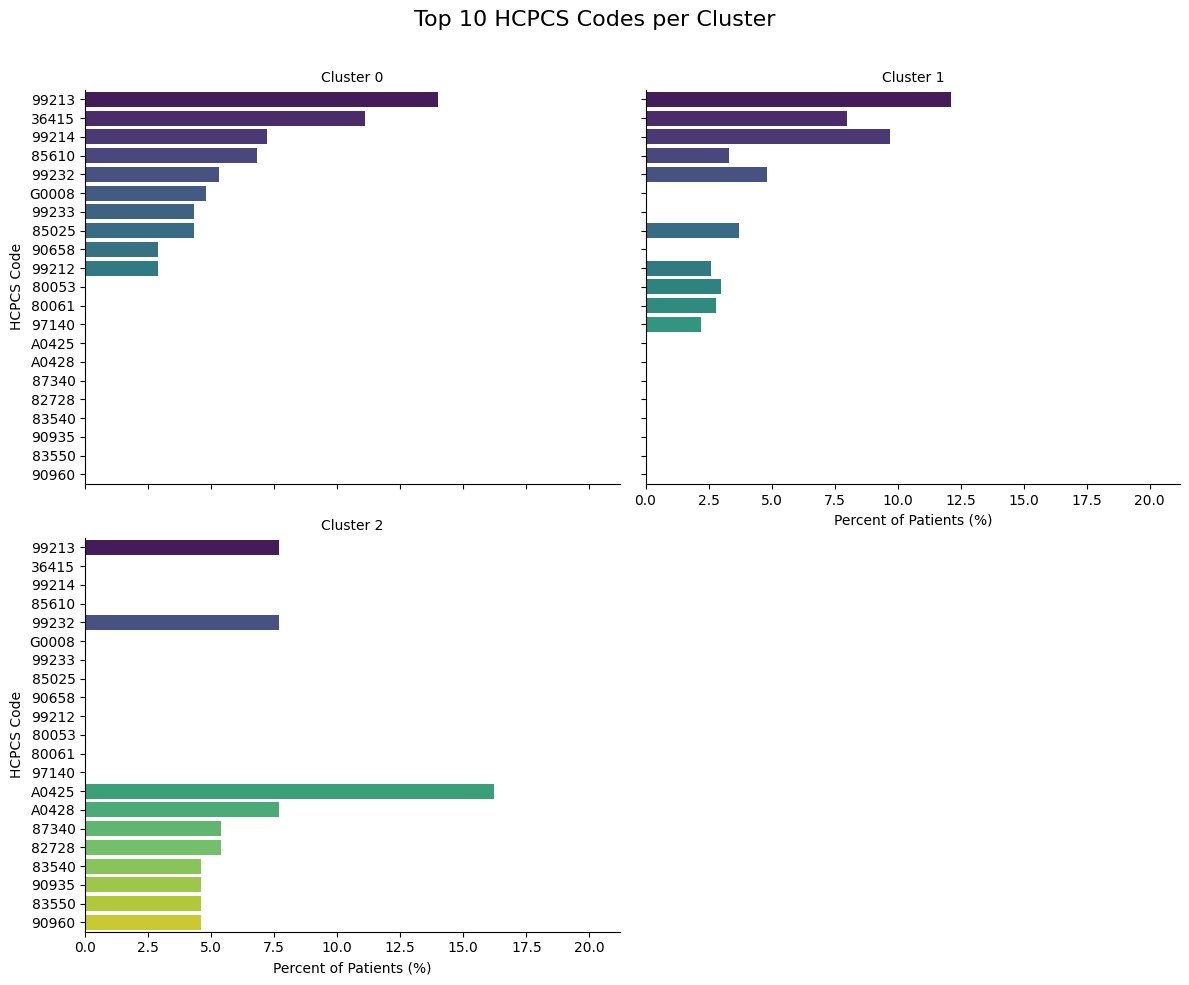

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Hitung Top HCPCS Code per Cluster
top_n = 10
cluster_hcpcs_summary = []

for cluster_id in sorted(df2['cluster'].unique()):
    df_cluster = df2[df2['cluster'] == cluster_id]
    hcpcs_counter = Counter([code for items in df_cluster['HCPCS_LIST'] for code in items
                             if not code.startswith('HAS_') and not code.startswith('AGE_') and not code.endswith('_PAYMENT')])
    total_patients = len(df_cluster)

    for hcpcs_code, count in hcpcs_counter.most_common(top_n):
        cluster_hcpcs_summary.append({
            'Cluster': f"Cluster {cluster_id}",
            'HCPCS_Code': hcpcs_code,
            'Count': count,
            'Percent': round(100 * count / total_patients, 1)
        })

# Buat DataFrame hasil
df_top_hcpcs = pd.DataFrame(cluster_hcpcs_summary)

# Plotting
g = sns.catplot(
    data=df_top_hcpcs,
    x='Percent',
    y='HCPCS_Code',
    col='Cluster',
    kind='bar',
    col_wrap=2,
    height=5,
    aspect=1.2,
    palette='viridis'
)

g.set_titles("{col_name}")
g.set_axis_labels("Percent of Patients (%)", "HCPCS Code")
g.set(xlim=(0, df_top_hcpcs['Percent'].max() + 5))
g.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Top 10 HCPCS Codes per Cluster", fontsize=16)
plt.show()


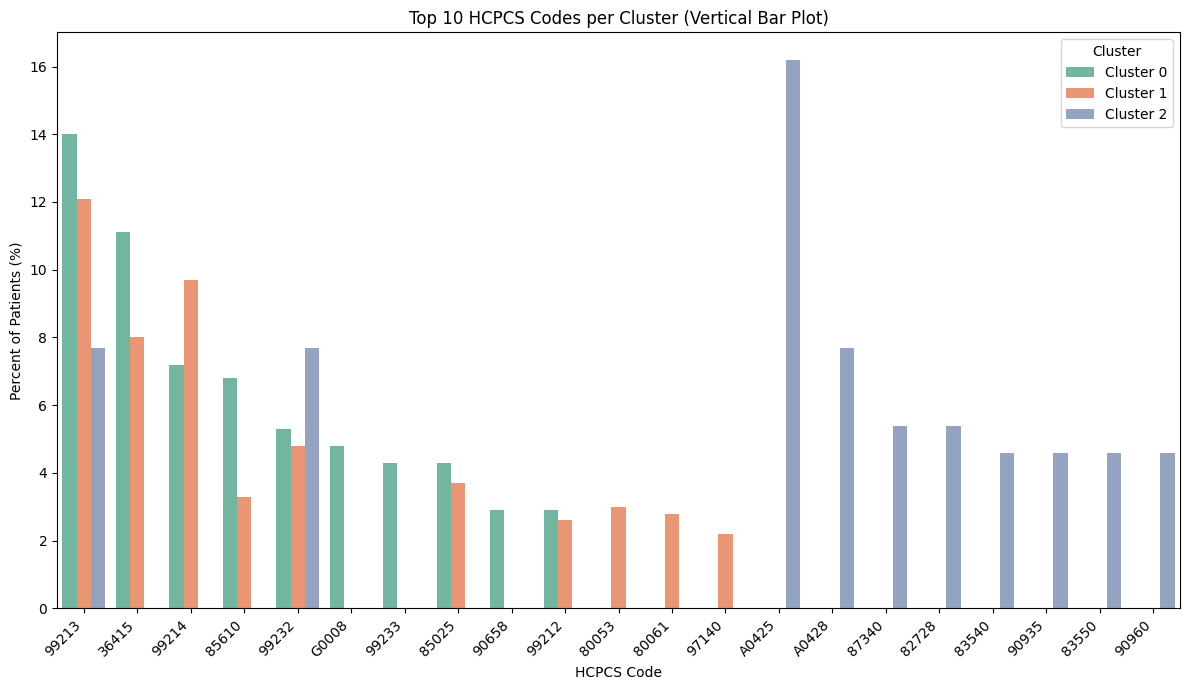

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Hitung Top HCPCS per Cluster
top_n = 10
cluster_hcpcs_summary = []

for cluster_id in sorted(df2['cluster'].unique()):
    df_cluster = df2[df2['cluster'] == cluster_id]
    hcpcs_counter = Counter([code for items in df_cluster['HCPCS_LIST'] for code in items
                             if not code.startswith('HAS_') and not code.startswith('AGE_') and not code.endswith('_PAYMENT')])
    total_patients = len(df_cluster)

    for hcpcs_code, count in hcpcs_counter.most_common(top_n):
        cluster_hcpcs_summary.append({
            'Cluster': f"Cluster {cluster_id}",
            'HCPCS_Code': hcpcs_code,
            'Count': count,
            'Percent': round(100 * count / total_patients, 1)
        })

# Buat DataFrame hasil
df_top_hcpcs = pd.DataFrame(cluster_hcpcs_summary)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_top_hcpcs,
    x='HCPCS_Code',
    y='Percent',
    hue='Cluster',
    dodge=True,
    palette='Set2'
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Percent of Patients (%)")
plt.xlabel("HCPCS Code")
plt.title("Top 10 HCPCS Codes per Cluster (Vertical Bar Plot)")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


heatmap

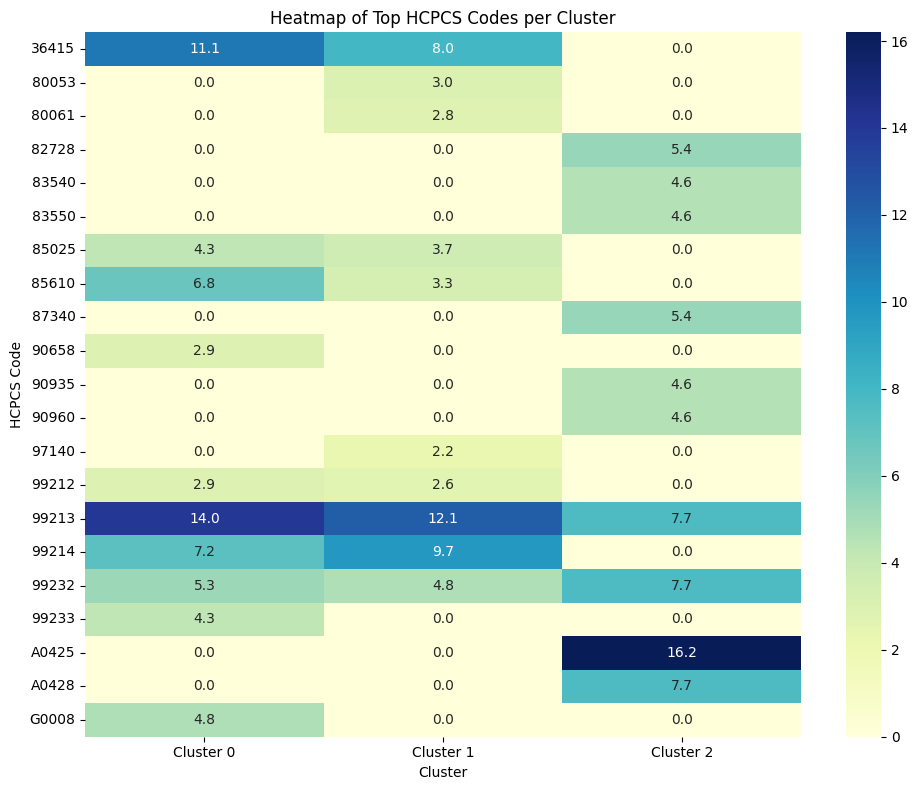

In [ ]:
import seaborn as sns

# Pivot HCPCS vs Cluster
heatmap_data = df_top_hcpcs.pivot(index='HCPCS_Code', columns='Cluster', values='Percent').fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap of Top HCPCS Codes per Cluster")
plt.ylabel("HCPCS Code")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


stacked bar plot

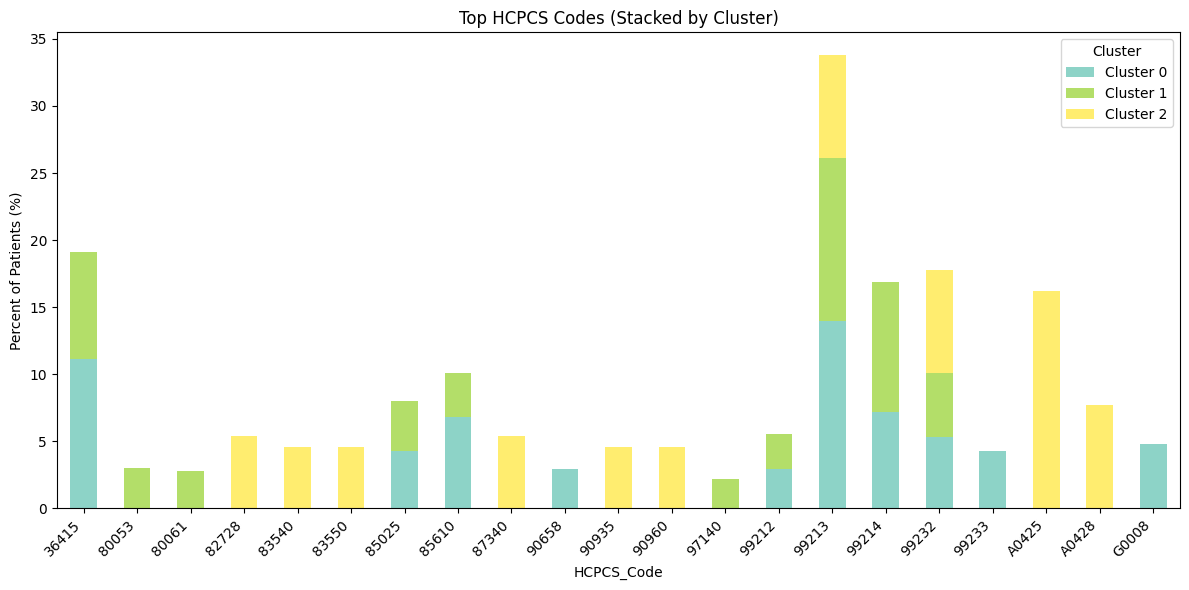

In [ ]:
# Gunakan pivot untuk stacked bar plot
df_pivot = df_top_hcpcs.pivot_table(index='HCPCS_Code', columns='Cluster', values='Percent', fill_value=0)
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')

plt.ylabel("Percent of Patients (%)")
plt.title("Top HCPCS Codes (Stacked by Cluster)")
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


visualisasi hpcs per kluster

In [ ]:
def display_top_hcpcs_text(df, top_n=10):
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_df = df[df['cluster'] == cluster_id]

        # Ambil HCPCS numerik saja
        hcpcs_flat = sum(cluster_df['HCPCS_LIST'], [])
        hcpcs_only = [code for code in hcpcs_flat if code.isdigit()]

        counter = Counter(hcpcs_only)
        total = sum(counter.values())
        top_hcpcs = counter.most_common(top_n)

        print(f"\n=== Cluster {cluster_id} ===")
        for i, (code, count) in enumerate(top_hcpcs, start=1):
            percent = round((count / total) * 100, 2)
            print(f"{i}. HCPCS Code {code} - {count}x ({percent}%)")


In [ ]:
display_top_hcpcs_text(df2, top_n=10)



=== Cluster 0 ===
1. HCPCS Code 99213 - 29x (9.12%)
2. HCPCS Code 36415 - 23x (7.23%)
3. HCPCS Code 99214 - 15x (4.72%)
4. HCPCS Code 85610 - 14x (4.4%)
5. HCPCS Code 99232 - 11x (3.46%)
6. HCPCS Code 99233 - 9x (2.83%)
7. HCPCS Code 85025 - 9x (2.83%)
8. HCPCS Code 90658 - 6x (1.89%)
9. HCPCS Code 99212 - 6x (1.89%)
10. HCPCS Code 93000 - 5x (1.57%)

=== Cluster 1 ===
1. HCPCS Code 99213 - 292x (7.23%)
2. HCPCS Code 99214 - 236x (5.84%)
3. HCPCS Code 36415 - 193x (4.78%)
4. HCPCS Code 99232 - 116x (2.87%)
5. HCPCS Code 85025 - 90x (2.23%)
6. HCPCS Code 85610 - 79x (1.96%)
7. HCPCS Code 80053 - 73x (1.81%)
8. HCPCS Code 80061 - 68x (1.68%)
9. HCPCS Code 99212 - 63x (1.56%)
10. HCPCS Code 97140 - 54x (1.34%)

=== Cluster 2 ===
1. HCPCS Code 99213 - 10x (5.26%)
2. HCPCS Code 99232 - 10x (5.26%)
3. HCPCS Code 87340 - 7x (3.68%)
4. HCPCS Code 82728 - 7x (3.68%)
5. HCPCS Code 83540 - 6x (3.16%)
6. HCPCS Code 90935 - 6x (3.16%)
7. HCPCS Code 83550 - 6x (3.16%)
8. HCPCS Code 90960 - 6x (3.16

In [ ]:
from collections import Counter
import ast

def display_top_hcpcs_overall(df, top_n=10):
    # Pastikan semua baris di HCPCS_LIST adalah list beneran
    hcpcs_flat = []
    for row in df['HCPCS_LIST']:
        if isinstance(row, str):
            try:
                row = ast.literal_eval(row)
            except:
                row = []
        hcpcs_flat.extend(row)

    # Filter hanya yang digit (HCPCS numerik)
    hcpcs_only = [code for code in hcpcs_flat if str(code).isdigit()]

    if not hcpcs_only:
        print("⚠️ Gak ada HCPCS numerik yang valid ditemukan.")
        return

    counter = Counter(hcpcs_only)
    total = sum(counter.values())
    top_hcpcs = counter.most_common(top_n)
    top_total = sum(count for _, count in top_hcpcs)

    print(f"\n=== TOP {top_n} HCPCS CODES DARI SEMUA KLUSTER ===")
    for i, (code, count) in enumerate(top_hcpcs, start=1):
        percent = round((count / total) * 100, 2)
        print(f"{i}. HCPCS Code {code} - {count}x ({percent}%)")

    print(f"\n>>> TOTAL KEMUNCULAN TOP {top_n} HCPCS (ALL CLUSTERS): {top_total}")


In [ ]:
display_top_hcpcs_overall(df2)



=== TOP 10 HCPCS CODES DARI SEMUA KLUSTER ===
1. HCPCS Code 99213 - 331x (7.28%)
2. HCPCS Code 99214 - 256x (5.63%)
3. HCPCS Code 36415 - 219x (4.82%)
4. HCPCS Code 99232 - 137x (3.01%)
5. HCPCS Code 85025 - 104x (2.29%)
6. HCPCS Code 85610 - 93x (2.05%)
7. HCPCS Code 80053 - 78x (1.72%)
8. HCPCS Code 80061 - 74x (1.63%)
9. HCPCS Code 99212 - 69x (1.52%)
10. HCPCS Code 99233 - 57x (1.25%)

>>> TOTAL KEMUNCULAN TOP 10 HCPCS (ALL CLUSTERS): 1418
